In [1]:
# Import necessary libraries for converting the dataset and data analysis
from nilmtk.dataset_converters import convert_redd
from nilmtk import DataSet
from nilmtk import Appliance

import pandas as pd
import random
import statistics as stats

import os

import re

import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')

In [2]:
# The conversion has already been done. There is no need to convert again.
#convert_redd('/mnt/research/sbarker/mhu/redd/redd-original', '/mnt/research/sbarker/mhu/redd.h5')
redd = DataSet('/mnt/research/sbarker/mhu/redd.h5')

In [3]:
# Helper function for set_up
# Return a dictionary tha maps each building to its list of appliances
def get_appliances(num_buildings, meters_buildings):
    building_2_apps = dict()
    for i in range(num_buildings):
        apps = [] # There can be multiple of the same devices in a building. This keeps the count.
        app_names = []
        for meter in meters_buildings[i].meters:
            # Extracts the name of the appliances in building i
            if meter.appliances:
                label_str = meter.appliances[0].label()
                app = re.search("'(.*)'", label_str)
                name = app.group(1)
            else:
                name = 'na'
            apps.append(name)
            if name in apps:
                count = apps.count(name) - 1
                if count:
                    name = f"{name}_{count}"
            app_names.append(name)
        building_2_apps[i + 1] = app_names
    return building_2_apps

In [4]:
# Helper function for set_up
# create a folder for each appliance in the building
def dir_app(building_2_apps, num_buildings, ds_name):
    for i in range(1, num_buildings+1):
        app_names = building_2_apps[i]
        for app in set(app_names):
            parent_dir = f"{ds_name}_profile/{ds_name}_b{i}"
            path = os.path.join(parent_dir, app)
            os.mkdir(path)
    print("Made a folder for each appliance in every building.")

In [5]:
# set up the necessary tools for generating an energy profile for the dataset
def set_up(path_h5):
    ds_obj = DataSet(path_h5)
    ds_name = ds_obj.metadata['name']
    # ds_name profile is the folder that contains all the profiles of that dataset.
    os.mkdir(os.path.join("/mnt/research/sbarker/mhu", f"{ds_name}_profile"))
    num_buildings = len(ds_obj.buildings)
    meters_buildings = []
    # Create a folder for each building inside the dataset folder
    for i in range(num_buildings):
        meters_buildings.append(ds_obj.buildings[i+1].elec)
        new_dir = f"{ds_name}_b{i+1}"
        parent_dir = f"{ds_name}_profile"
        path = os.path.join(parent_dir, new_dir)
        os.mkdir(path)
    building_2_apps = get_appliances(num_buildings, meters_buildings)
    # Make a folder for each appliance inside the building folder
    dir_app(building_2_apps, num_buildings, ds_name)
    return [ds_obj, ds_name, meters_buildings, building_2_apps]

In [6]:
# Return a list of the durations of every active period that a meter mesures.
# In most cases, 1 meter corresponds to 1 appliance.
def get_durations(meter):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    duration_map = dict()
    for i in range(num_periods):
        curr_period = active_periods[i]
        curr_end = curr_period.index[-1].timestamp()
        curr_start = curr_period.index[0].timestamp()
        diff = curr_end - curr_start
        duration_map[i]= diff
    return duration_map

In [7]:
# Plot the longest activation period of a meter
# Saves the plot inside the appliance folder
def longest_period(meter, appname, building_idx):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if not num_periods:
        print(f'There are NO activation period for {appname}.')
        return
    duration_map = get_durations(meter)
    max_idx = 0
    max_dur = duration_map[0]
    for ap in range(num_periods):
        duration = duration_map[ap]
        if duration > max_dur:
            max_dur = duration
            max_idx = ap
    
    # Plot and save the graphs
    # The scale of the axis is adapted for each meter. Be careful reading the axises.
    long = active_periods[max_idx].plot()
    plt.xlabel("Timestamps") # Unable to adjust the unit to reflect the scale.
    plt.ylabel("Durations")
    plt.title(f'Longest Activation Period for {appname}')
    fig = long.get_figure()
    fig.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/longest_ap.png')
    long.clear()

In [8]:
# Plot the shortest activation period of a meter
# Saves the plot inside the appliance folder
def shortest_period(meter, appname, building_idx):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if not num_periods:
        print(f'There are NO activation period for {appname}.')
        return
    duration_map = get_durations(meter)
    
    min_idx = 0
    min_dur = duration_map[0]
    for ap in range(num_periods):
        duration = duration_map[ap]
        if duration <= min_dur:
            min_dur = duration
            min_idx = ap
    # Plot and save the graphs
    # The scale of the axis is adapted for each meter. Be careful reading the axises.
    short = active_periods[min_idx].plot()
    plt.xlabel("Timestamps") # Unable to adjust the unit to reflect the scale.
    plt.title(f'Shortest Activation Period for {appname}')
    plt.show()
    fig = short.get_figure()
    fig.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/shortest_ap.png')
    short.clear()
    
    print("SUCCESS! Exported the longest ap and shortest ap plots.")

In [9]:
# For a single appliance, generate 3% of the number of active periods. 
# The number of plots produced will be capped at 6. Minimal is 1
# Saves the plot inside the appliance folder
def random_ap(meter, appname, building_idx):
    #TODO: Label y-axis
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if not num_periods:
        print(f'There are NO activation period for {appname}.')
        return
    
    num_plots = int(num_periods * 0.03)
    num_plots = max(1, num_plots)
    num_plots = min(6, num_plots)

    periods = random.sample(range(0, num_periods), num_plots)
    for idx in periods:
        plot = active_periods[idx].plot()
        plt.xlabel("Timestamps") # Provide units
        plt.ylabel("Wattage")
        plt.title(f'Activation Period {idx} for {appname}')
        fig = plot.get_figure()
        fig.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/random_ap_{idx}.png')
        plot.clear()

In [10]:
# Plot the duration of all the activation periods of an appliance (assuming 1 appliance per meter)
# Saves the plot inside the appliance folder
# Has the option to turn on or off denoise
def plot_ap_durations(meter, appname, building_idx, denoised = True):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if not num_periods:
        print(f'There are NO activation period for {appname}.')
        return

    duration_map = get_durations(meter)
    durations = list(duration_map.values())
    
    ys = np.array(durations)
    size = len(durations)
    if denoised and size > 1:
        ys = denoise(durations)
    plt.plot(ys, 'o')
    plt.xlabel("Activation Periods Indices")
    plt.ylabel(f"Duration of Activation Periods")

    if denoised and size > 1: 
        plt.title(f"Denoised Duration of Activation Periods for {appname} in Building {building_idx}")
        plt.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/denoised_ap_durations.png')
    else:
        plt.title(f"Undenoised Duration of Activation Periods for {appname} in Building {building_idx}")
        plt.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/undenoised_ap_durations.png')
    plt.clf()

In [11]:
# Plot the gaps bewteen activation periods of an appliance (assuming 1 appliance per meter)
# gaps: the durationn of inactive periods (from the end of the previous activation period to the current start)
# Saves the plot inside the appliance folder
def get_ap_gaps(meter, appname):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if num_periods < 2:
        print(f'Insufficient active periods to calculate gaps.')
        return
    
    diff_map = dict()
    
    for i in range(num_periods - 1):
        curr_period = active_periods[i]
        curr_end = curr_period.index[-1].timestamp()
        next_period = active_periods[i + 1]
        next_start = next_period.index[0].timestamp()
        diff = next_start - curr_end
        diff_map[i]= diff
    diffs = list(diff_map.values())
    
    return diffs

In [12]:
# Plot the gaps between activation periods
# Has the option to turn on or off denoise
# Saves the plot inside the appliance folder
def plot_ap_gaps(meter, appname, building_idx, denoised = True):
    diffs = get_ap_gaps(meter, appname)
    if not diffs:
        return
    size = len(diffs)
    ys = np.array(diffs)
    
    if denoised and size > 1:
        ys = denoise(diffs)
    
    plt.plot(ys, 'o')
    plt.xlabel("AP Gaps Indices")
    plt.ylabel(f"Gaps of Activation Periods")
    
    if denoised and size > 1:
        plt.title(f"Denoised Gaps of Activation Periods for {appname} in Building {building_idx}")
        plt.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/denoised ap_gaps.png')
    else:
        plt.title(f"Undenoised Gaps of Activation Periods for {appname} in Building {building_idx}")
        plt.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/undenoised_ap_gaps.png')
        
    plt.close()

In [13]:
# For each meter, compute the average energy usage of each activation period.
# Plots the averages for all activation periods of the meter.
# The x-axis are indices for the activation periods.
# Saves the plot inside the appliance folder
def plot_avg(meter, appname, building_idx, durations):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if not num_periods:
        print(f'There are NO activation period for {appname}.')
        return
    
    avg_list = []
    for ap in active_periods:
        avg = stats.mean(ap)
        avg_list.append(avg)

    xs = np.array([x for x in range(num_periods)])
    ys = np.array(avg_list)

    plt.plot(xs, ys, 'o')

    plt.xlabel("AP Indices")
    plt.ylabel(f"Average Usage for Individual Activation Periods")
    plt.title(f"Average Usage During Activation for {appname} in Building {building_idx}")
    plt.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/avg_usage.png')
    plt.close()

In [14]:
# Same as plot_avg except we compute variances instead of averages
# Saves the plot inside the appliance folder
def plot_var(meter, appname, building_idx):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if not num_periods:
        print(f'There are NO activation period for {appname}.')
        return
    
    var_list = []
    for ap in active_periods:
        # Skip calculation for activation periods less than 1 data point
        if len(ap) > 1:
            v = stats.variance(ap)
            var_list.append(v)

    xs = np.array([x for x in range(num_periods)])
    ys = np.array(var_list)

    plt.plot(xs, ys, 'o')

    plt.xlabel("AP Indices")
    plt.ylabel(f"Variance in Usage for Individual Activation Periods")
    plt.title(f"Variance in Usage During Activation for {appname} in Building {building_idx}")
    plt.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/var_usage.png')
    plt.close()

In [15]:
# avg_list is the list of the average energy usage of all active periods 
# stdv_list is the list of the variance of energy usage of each active periods for all periods
def usage_list(meter, appname):
    active_periods = meter.get_activations()
    num_periods = len(active_periods)
    if not num_periods:
        print(f'There are NO activation period for {appname}.')
    avg_list = []
    stdv_list = []
    #for ap in active_periods:
    for ap in active_periods:
        ap = [v for v in ap.values]
        if len(ap) > 0:
            avg = stats.mean(ap)
            avg_list.append(avg)
            #print(avg_list)
        if len(ap) > 1:
            stdv = np.std(ap)
            stdv_list.append(stdv)
    return [avg_list, stdv_list]

In [16]:
# Applies the IQR (interquantile range) method
# Returns a denoise list
def denoise(data):
    new_data = sorted(data)
    q1_idx = int(len(new_data) * 0.25)
    q3_idx = int(len(new_data) * 0.75)
    Q1 = new_data[q1_idx]
    Q3 = new_data[q3_idx]
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    cleaned = []
    for d in data:
        if d <= upper and d >= lower:
            cleaned.append(d)
    return cleaned

In [17]:
# Produce statistics about the meter. Saved in each appliance folder.
# a_a: the average energy level when the appliance is active. It is the average of the average list produced by usage_list()
# a_v: the average variance of energy level during active periods. Assess the stability of energy usage while active. i.e. does energy usage vary a lot within each active periods.
# s_a: the standard deviation of the average list. It assesses the varaibility among active periods. i.e. are different active periods similar in energy level
# Has the option to turn on and off denoise
def usage_stats(meter, appname, building_idx, denoised = True):
    lists = usage_list(meter, appname)
    if not lists:
        return
    avg_list = lists[0]
    stdv_list = lists[1]
    
    if denoised:
        if avg_list:
            avg_list = denoise(avg_list)
        if stdv_list:
            stdv_list = denoise(stdv_list)
    file = open(f"/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/usage_stats.txt", "a")
    if stdv_list:
        a_v = stats.mean(stdv_list) # Average of the variances
        if denoised:
            file.write(f"The average of denoised standard deviations is {a_v}.\n")
        else:
            file.write(f"The average of undenoised standard deviations is {a_v}.\n")
    
    if avg_list:
        a_a = stats.mean(avg_list) # Average of the averages
        if denoised:
            file.write(f"The average of denoised averages is {a_a}.\n")
        else:
            file.write(f"The average of undenoised averages is {a_a}.\n")
    
        if len(avg_list) > 1:
            s_a = np.std(avg_list) # standard deviation of the averages
            if denoised:
                file.write(f"The standard deviation of denoised averages is {s_a}.\n")
            else:
                file.write(f"The standard deviation of undenoised averages is {s_a}.\n")
        return a_v
            
    file.close()

In [18]:
# Produce statistics about the durations of active periods. Saved in each appliance folder.
# avg: the average duration of an activation period.
# var: the variance of activation period. i.e. do the activation periods last similar in time
# Provides option of turning on or off denoise
def duration_stats(durations, meter, appname, building_idx, denoised = True):
    file = open(f"/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/duration_stats.txt", "a")
    
    size = len(durations)
    if denoised and size > 1:
        durations = denoise(durations)

    avg = stats.mean(durations)
    file.write(f"Average Durations of Activation Periods: {avg} in seconds.\n")
    
    if len(durations) == 1:
        print("Not enough data points to generate variance.")
    else:
        var = stats.variance(durations)
        file.write(f"Variance of Durations of Activation Periods: {var} in seconds.\n")
    file.close()

In [1]:
# Histogram that shows the frequency of values.
# Saves the plot in the appliance folder.
# i.e. are there paritcular values that are more frequent than others
def get_hist(meter, appname, data, description, building_idx, xlabel, title):
    plt.figure(figsize=(6,3.5))
    plt.hist(data, bins=10, color='skyblue', edgecolor='black')
    plt.xlabel(f"{xlabel}")
    plt.ylabel("Frequencies")
    plt.title(f'Distribution of {title} for {appname}')
    plt.savefig(f'/mnt/research/sbarker/mhu/REDD_profile/REDD_b{building_idx}/{appname}/{description}_distributions.png', bbox_inches='tight', dpi=150)
    plt.show()

In [21]:
# Generate a profile for the entire dataset
def data_set_profile(dataset):
    ds_obj, ds_name, meters_buildings, building_2_apps = set_up("/mnt/research/sbarker/mhu/redd.h5")
    num_buildings = len(meters_buildings)
    for j in range(num_buildings):
        d_maps = dict()
        profile(j, meters_buildings, building_2_apps, d_maps)
        rank = sorted(d_maps.keys(), key=lambda item: item[1], reverse=True)
        file = open(f"/mnt/research/sbarker/mhu/REDD_profile/REDD_b{j+1}/variance_ranking.txt", "a")
        file.write(f"The degree of variance of appliances in this building / collection is {rank}.")
        file.close()

In [24]:
# generate an energy profile for a building
def profile(j, meters_buildings, building_2_apps, d_maps):
    b_meters = meters_buildings[j].meters
    app_names = building_2_apps[j+1]
    for i in range(len(app_names)):
        meter = b_meters[i]
        appname = app_names[i]
        durations_map = get_durations(meter)
        durations = list(durations_map.values())
        
        longest_period(meter, appname, j+1)
        shortest_period(meter, appname, j+1)
        random_ap(meter, appname, j+1)
        plot_ap_durations(meter, appname, j+1)
        plot_ap_gaps(meter, appname, j+1)
        
        a_v = usage_stats(meter, appname, j+1)
        if a_v:
            d_maps[appname] = a_v

        if durations:
            durations = denoise(durations)
            if durations:
                get_hist(meter, appname, durations, "durations", j+1, "time", "Activity Duration")
            gaps = get_ap_gaps(meter, appname)
            if gaps:
                gaps = denoise(gaps)
                if gaps:
                    get_hist(meter, appname, gaps, "ap_gaps", j+1, "time", "Inactivity Duration")
            ap_intensity = usage_list(meter, appname)[0]     
            get_hist(meter, appname, ap_intensity, "ap_intensities", j+1, "wattage", "Average Wattage During Activation")

            plot_avg(meter, appname, j+1, durations)
            plot_var(meter, appname, j+1)
        
            duration_stats(durations, meter, appname, j+1)
            
        else:
            print(f'There are NO activation period for {appname}.')

Made a folder for each appliance in every building.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
Insufficient active periods to calculate gaps.
There are NO activation period for na.
{}
There are NO activation period for na.
There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
Insufficient active periods to calculate gaps.
There are NO activation period for na_1.
{}
There are NO activation period for na_1.


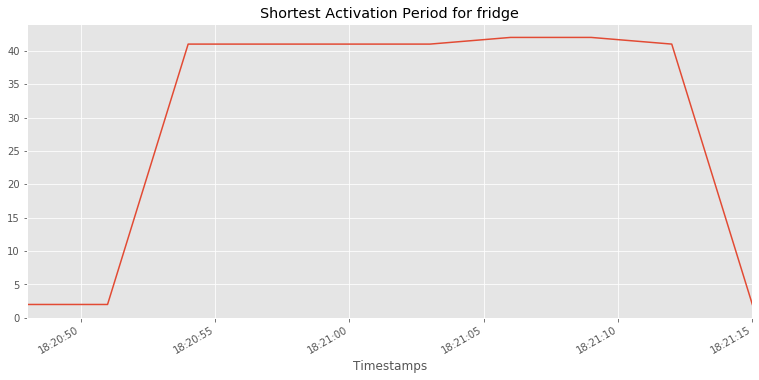

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928}


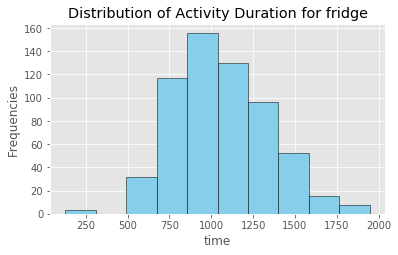

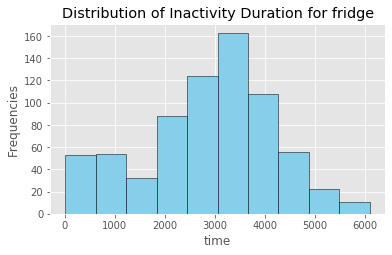

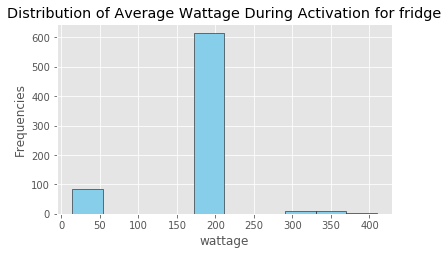

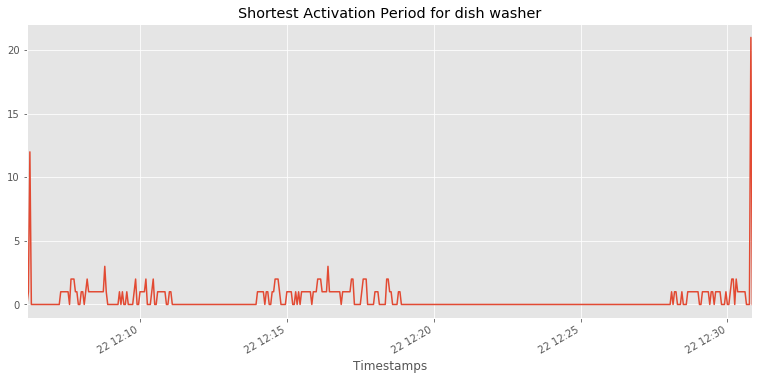

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666}


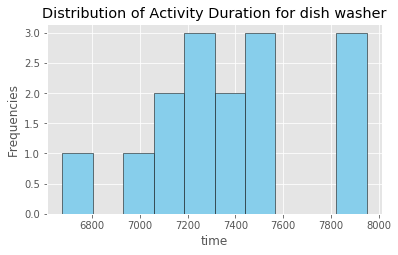

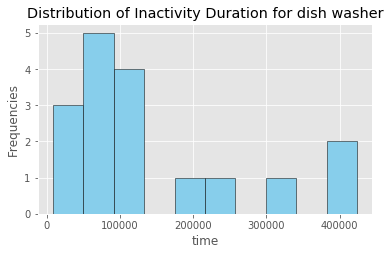

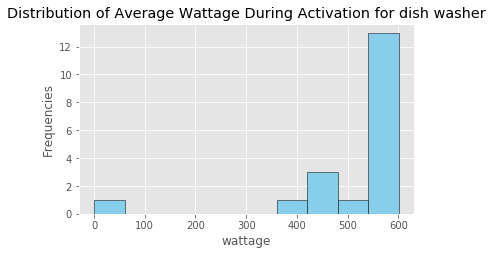

There are NO activation period for sockets.
There are NO activation period for sockets.
There are NO activation period for sockets.
There are NO activation period for sockets.
Insufficient active periods to calculate gaps.
There are NO activation period for sockets.
{'fridge': 19.419928, 'dish washer': 465.01666}
There are NO activation period for sockets.
There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
Insufficient active periods to calculate gaps.
There are NO activation period for sockets_1.
{'fridge': 19.419928, 'dish washer': 465.01666}
There are NO activation period for sockets_1.


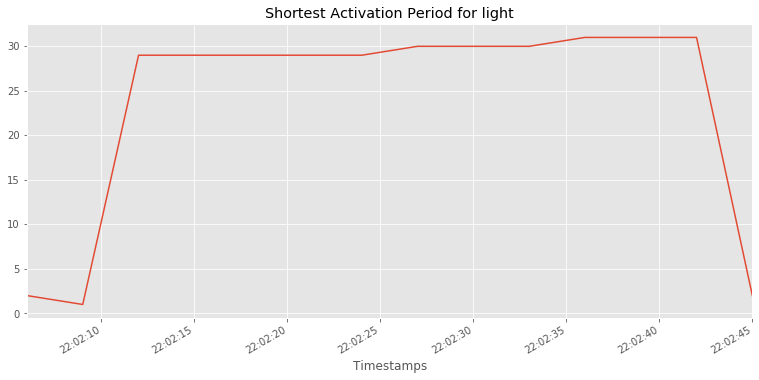

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155}


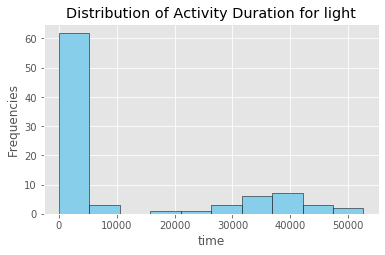

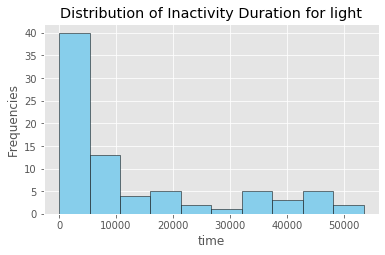

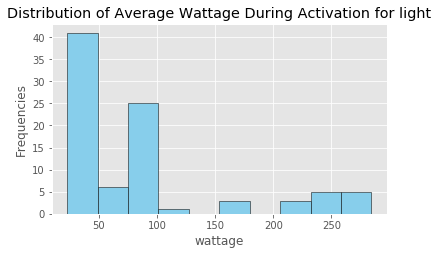

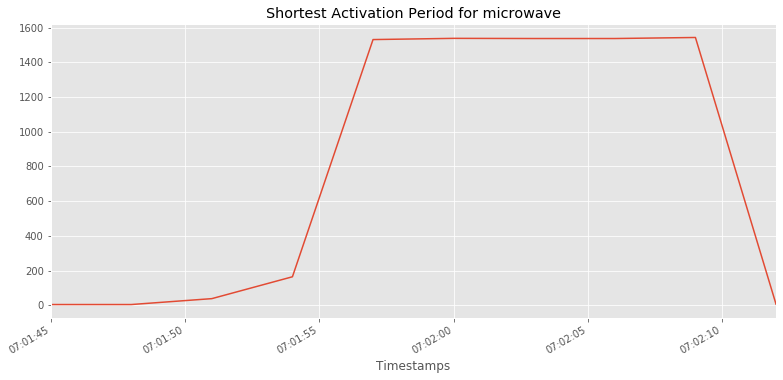

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801}


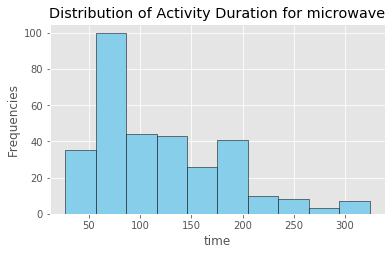

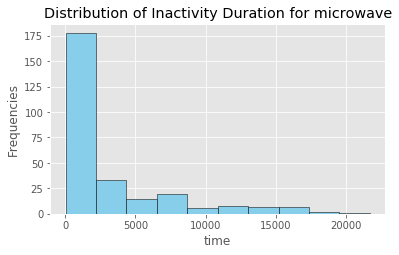

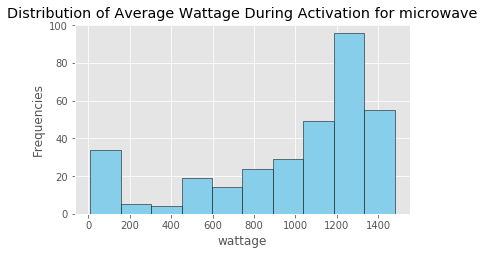

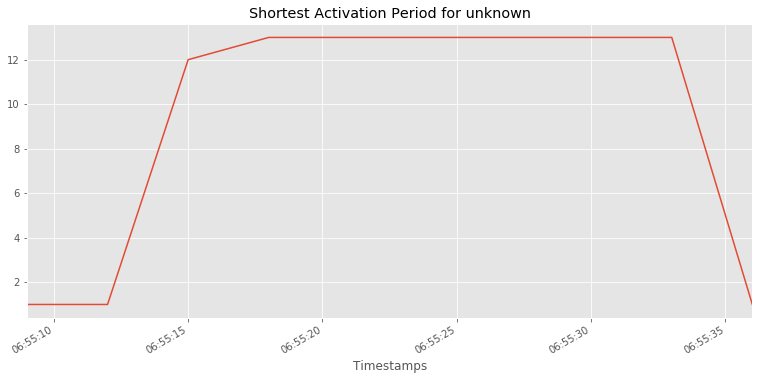

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194}


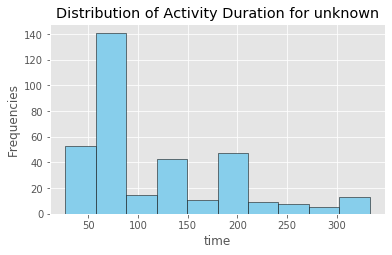

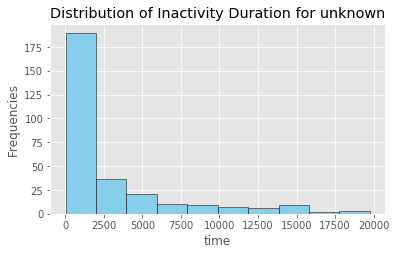

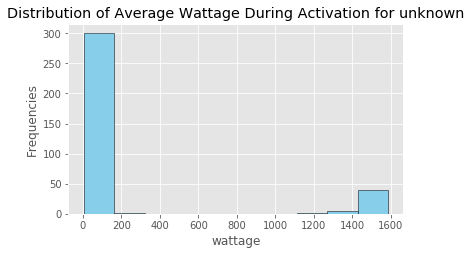

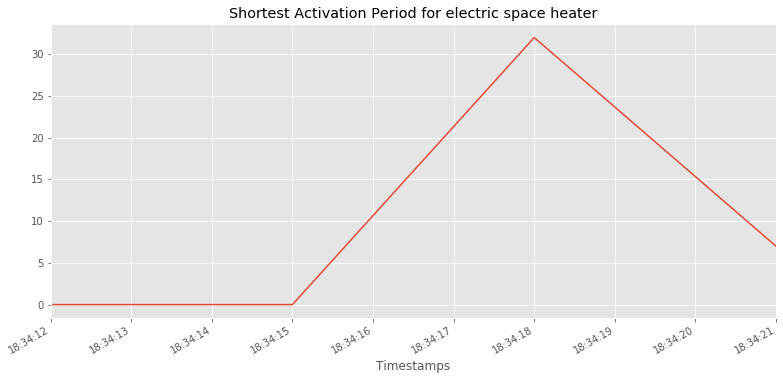

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577}


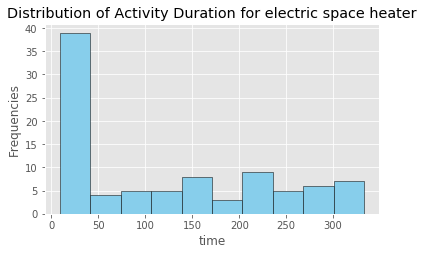

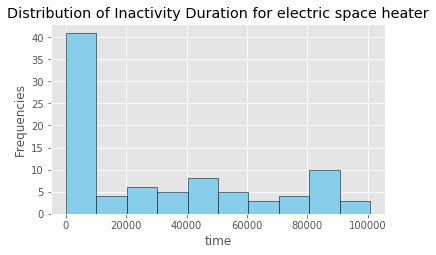

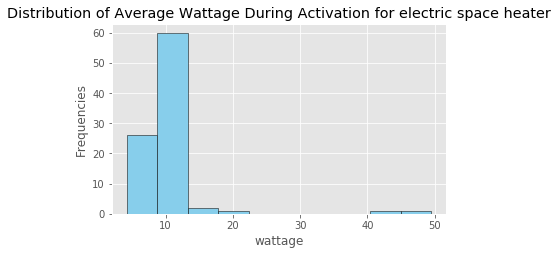

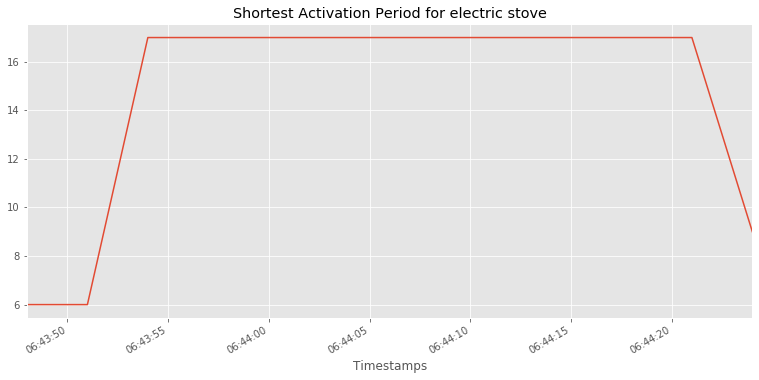

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144}


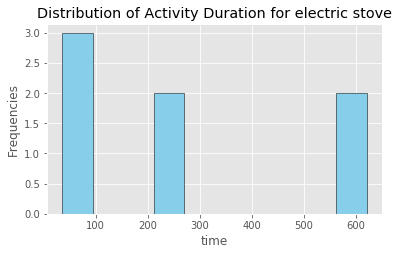

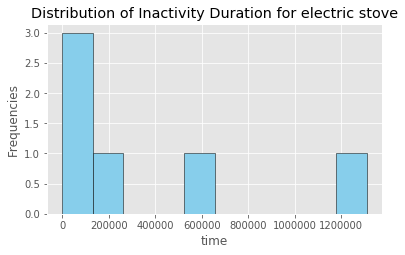

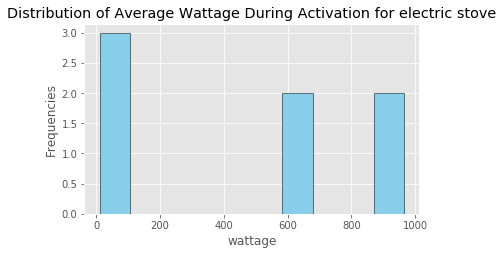

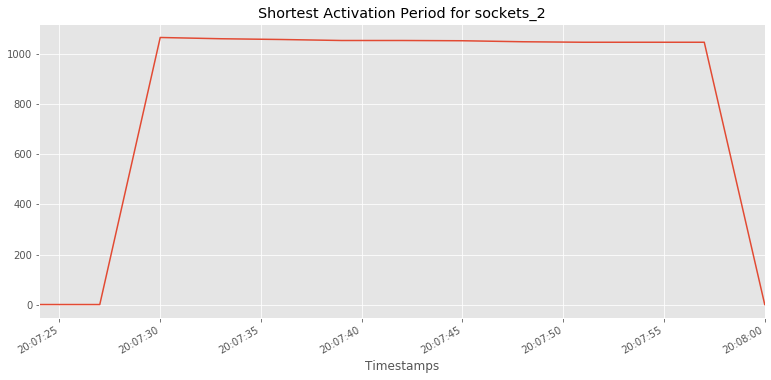

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144, 'sockets_2': 177.8375}


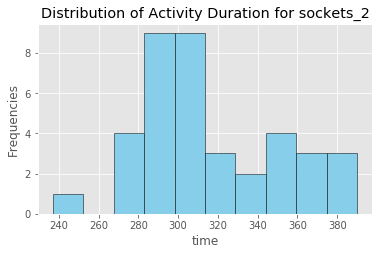

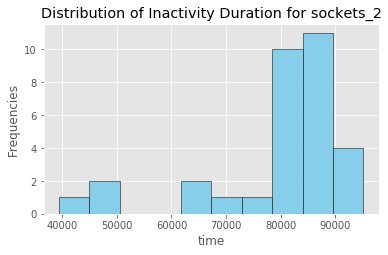

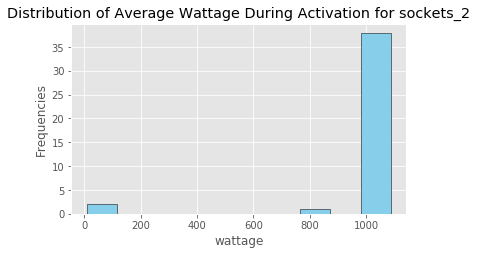

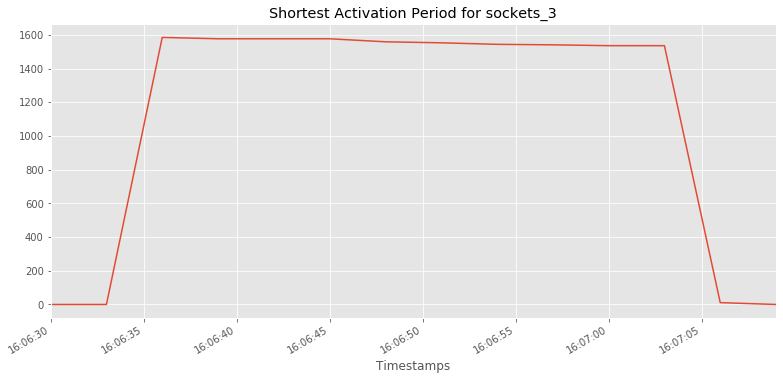

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144, 'sockets_2': 177.8375, 'sockets_3': 418.79288}


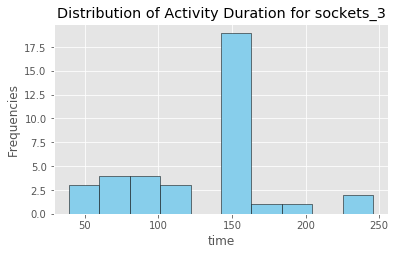

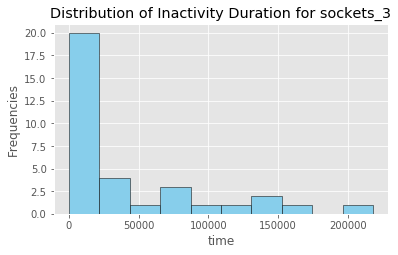

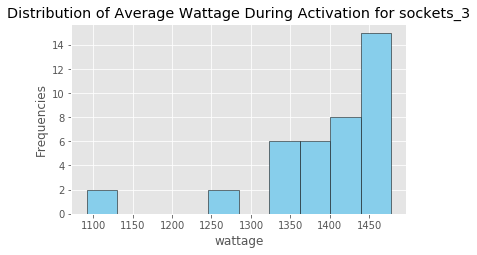

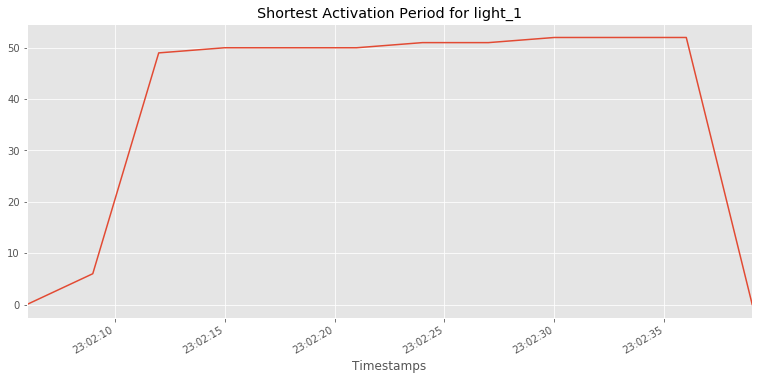

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144, 'sockets_2': 177.8375, 'sockets_3': 418.79288, 'light_1': 3.7740352}


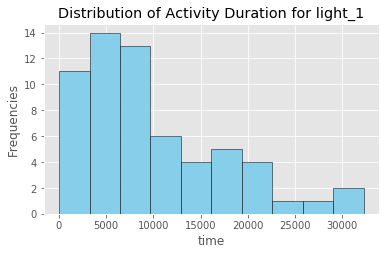

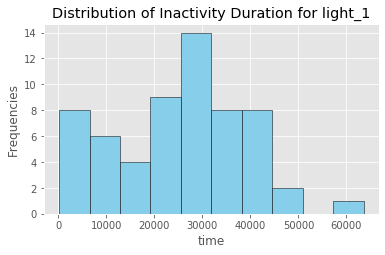

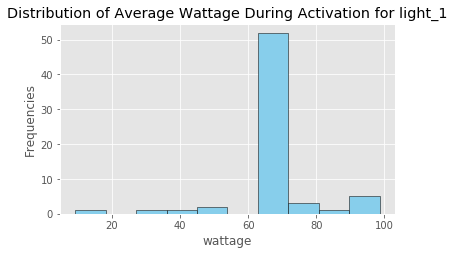

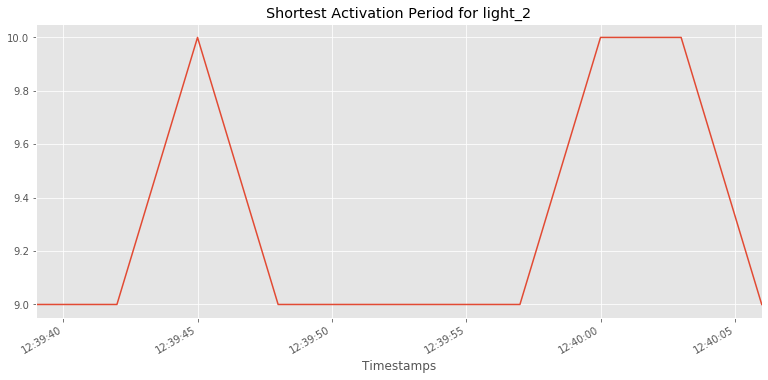

SUCCESS! Exported the longest ap and shortest ap plots.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144, 'sockets_2': 177.8375, 'sockets_3': 418.79288, 'light_1': 3.7740352, 'light_2': 0.47327346}


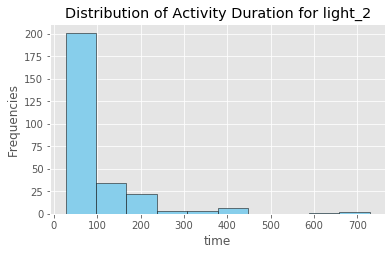

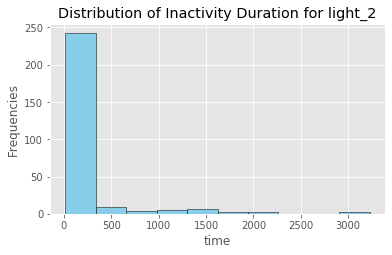

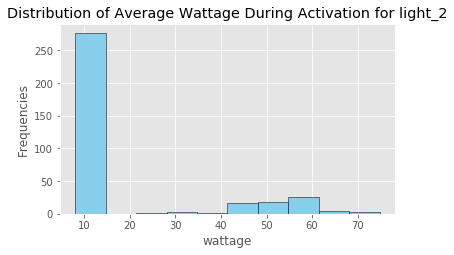

There are NO activation period for unknown_1.
There are NO activation period for unknown_1.
There are NO activation period for unknown_1.
There are NO activation period for unknown_1.
Insufficient active periods to calculate gaps.
There are NO activation period for unknown_1.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144, 'sockets_2': 177.8375, 'sockets_3': 418.79288, 'light_1': 3.7740352, 'light_2': 0.47327346}
There are NO activation period for unknown_1.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeter

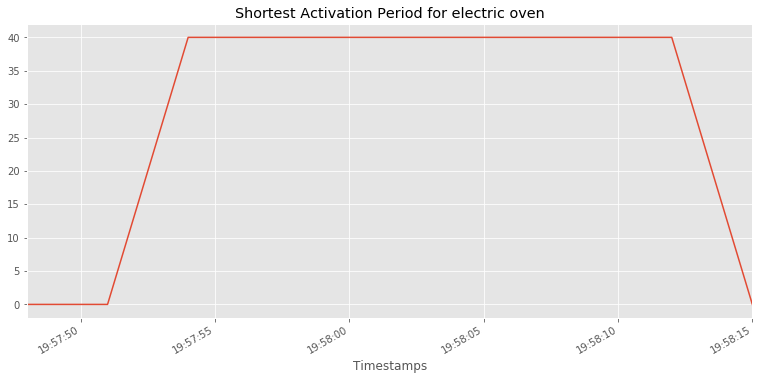

SUCCESS! Exported the longest ap and shortest ap plots.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144, 'sockets_2': 177.8375, 'sockets_3': 418.79288, 'light_1': 3.7740352, 'light_2': 0.47327346, 'electric oven': 534.8161}


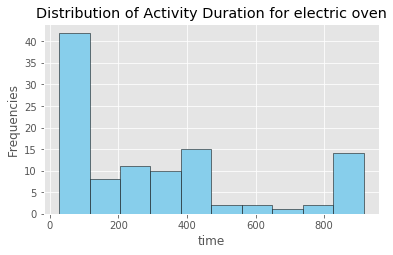

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


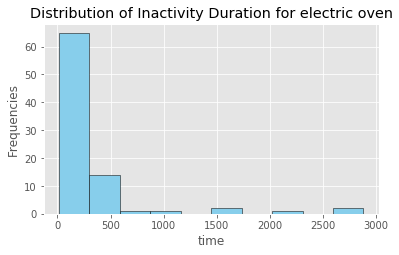

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


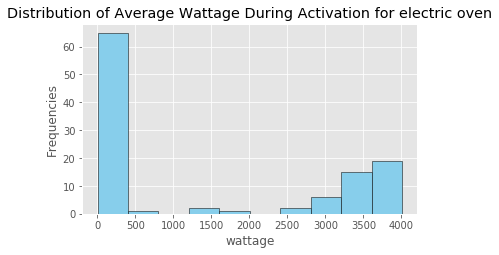

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


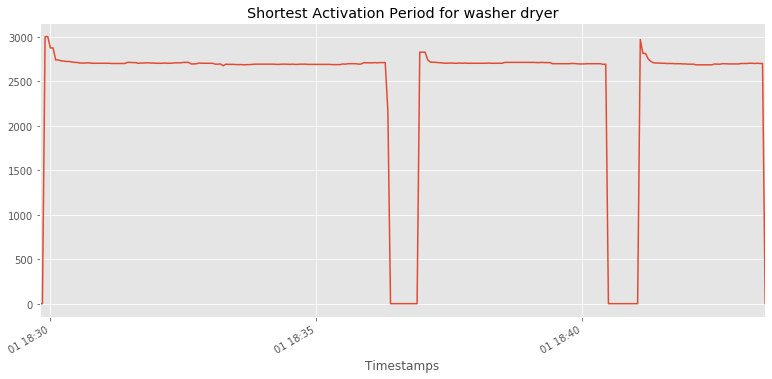

SUCCESS! Exported the longest ap and shortest ap plots.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
{'fridge': 19.419928, 'dish washer': 465.01666, 'light': 13.260155, 'microwave': 605.8801, 'unknown': 3.7211194, 'electric space heater': 3.1896577, 'electric stove': 398.07144, 'sockets_2': 177.8375, 'sockets_3': 418.79288, 'light_1': 3.7740352, 'light_2': 0.47327346, 'electric oven': 534.8161, 'washer dryer': 8

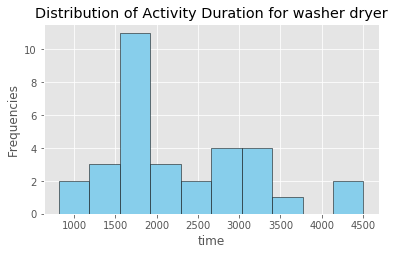

Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


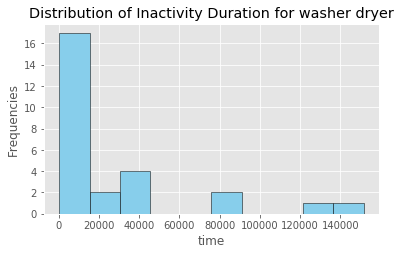

Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


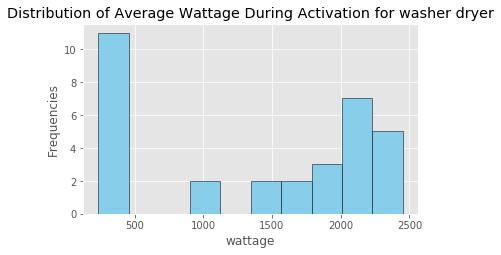

Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


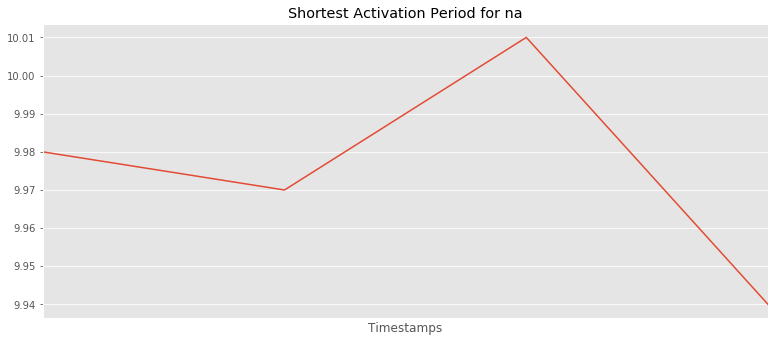

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959}


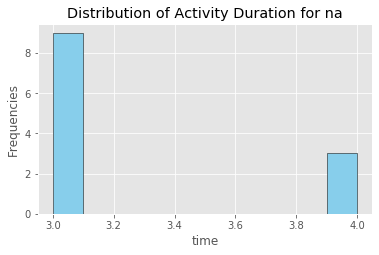

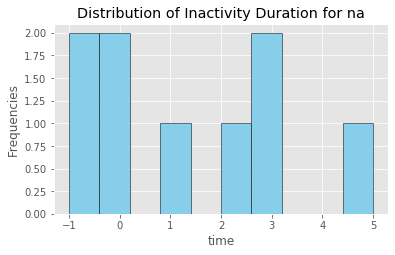

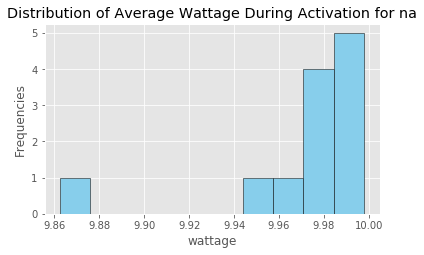

There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
Insufficient active periods to calculate gaps.
There are NO activation period for na_1.
{'na': 0.01984959}
There are NO activation period for na_1.


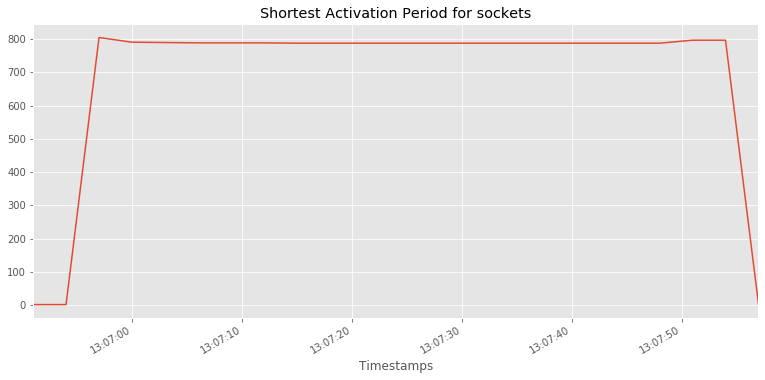

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959, 'sockets': 124.25029}


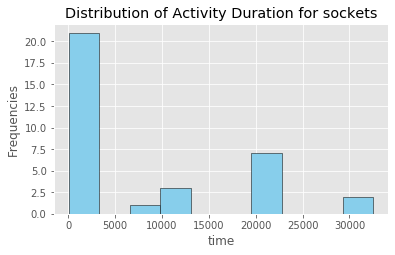

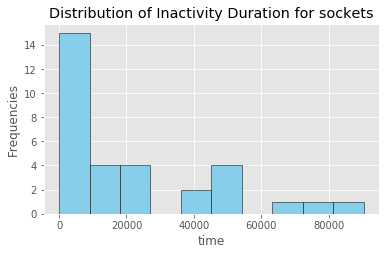

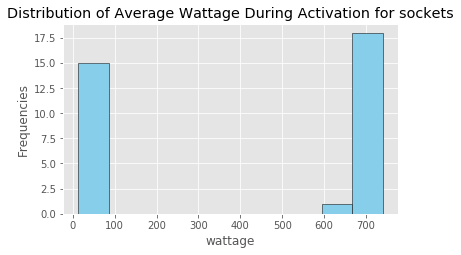

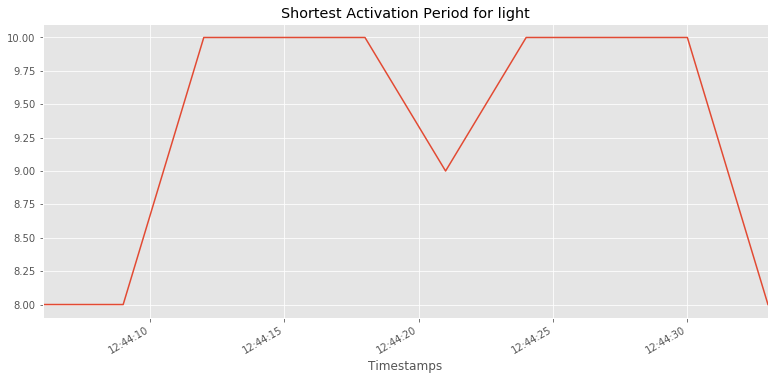

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297}


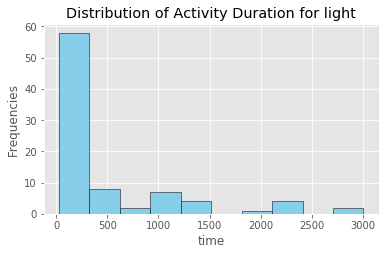

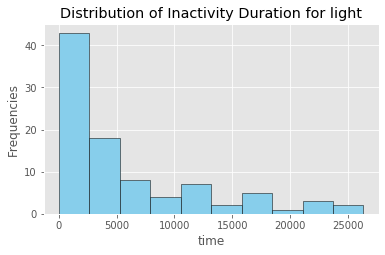

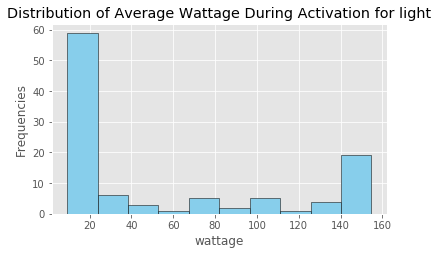

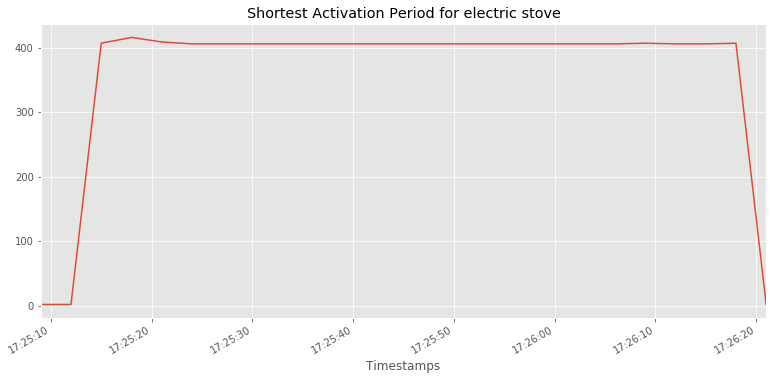

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297, 'electric stove': 126.67313}


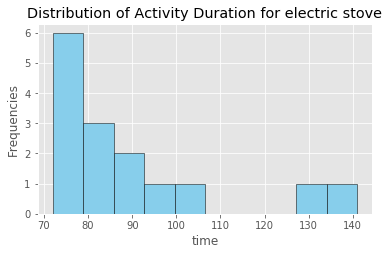

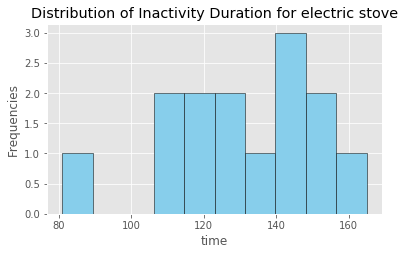

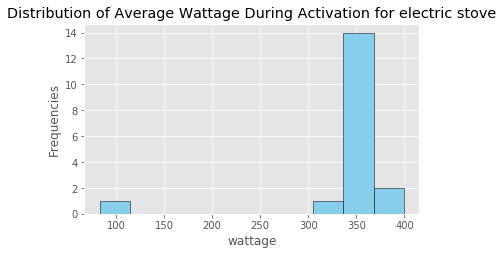

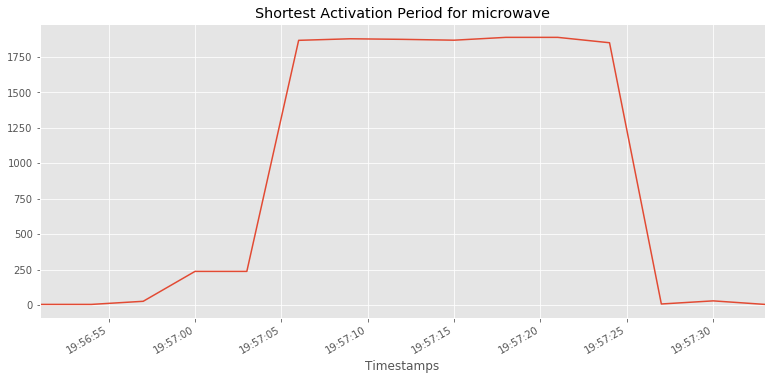

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297, 'electric stove': 126.67313, 'microwave': 559.8179}


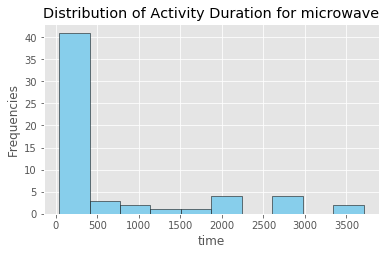

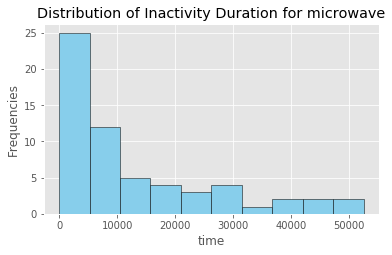

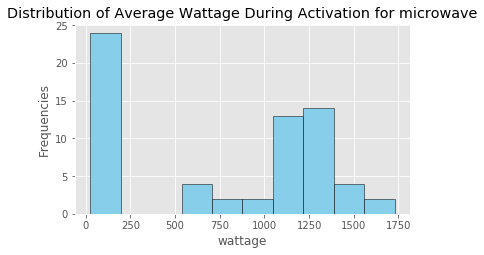

There are NO activation period for washer dryer.
There are NO activation period for washer dryer.
There are NO activation period for washer dryer.
There are NO activation period for washer dryer.
Insufficient active periods to calculate gaps.
There are NO activation period for washer dryer.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297, 'electric stove': 126.67313, 'microwave': 559.8179}
There are NO activation period for washer dryer.


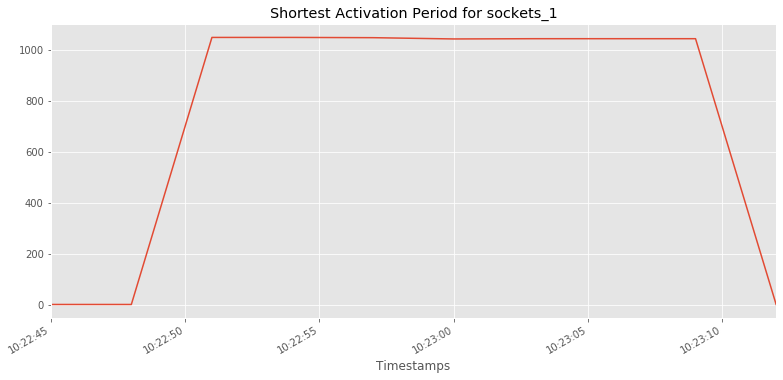

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297, 'electric stove': 126.67313, 'microwave': 559.8179, 'sockets_1': 312.7927}


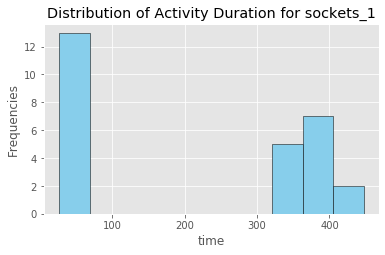

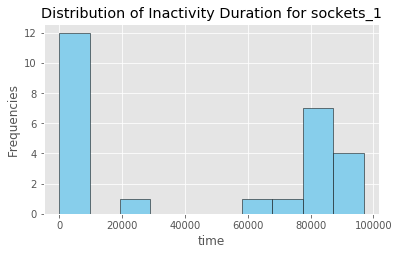

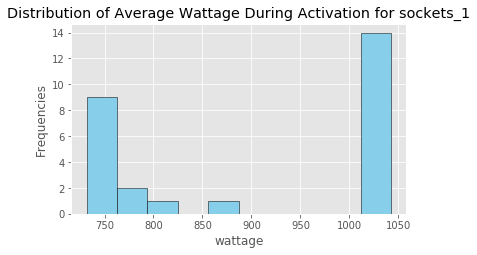

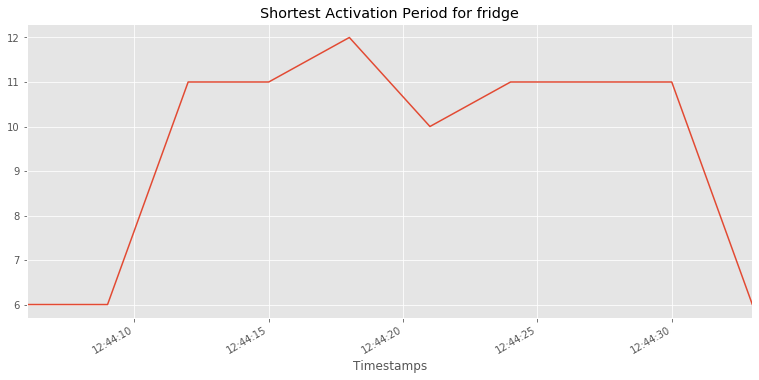

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297, 'electric stove': 126.67313, 'microwave': 559.8179, 'sockets_1': 312.7927, 'fridge': 14.883079}


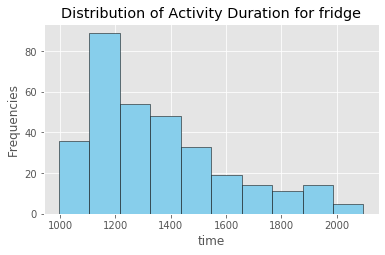

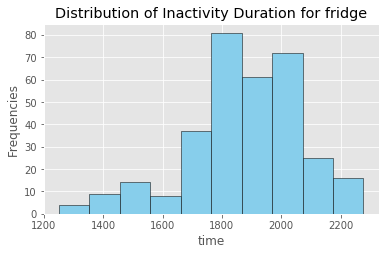

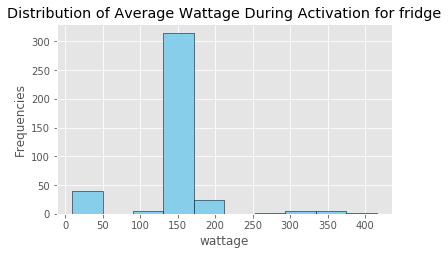

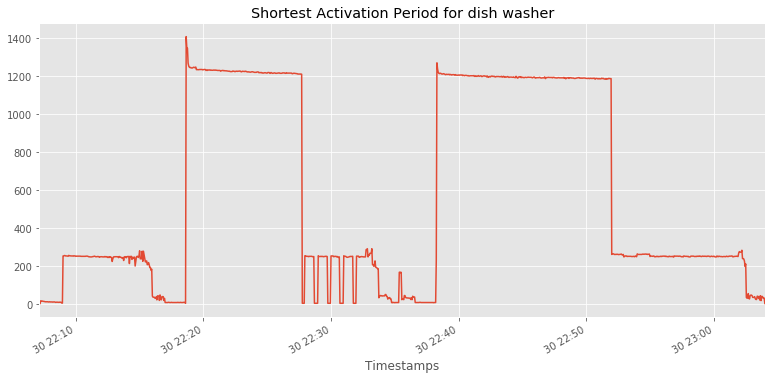

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297, 'electric stove': 126.67313, 'microwave': 559.8179, 'sockets_1': 312.7927, 'fridge': 14.883079, 'dish washer': 517.067}


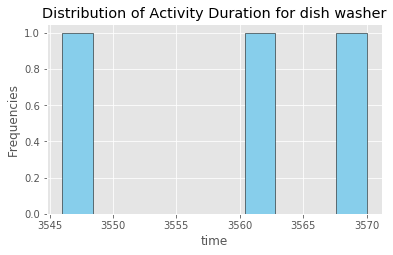

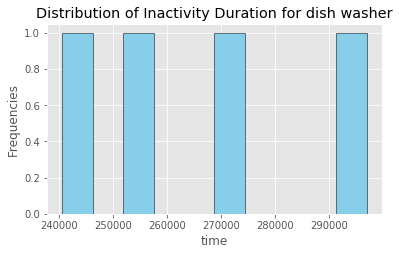

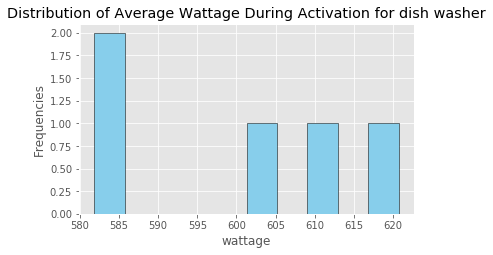

There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
Insufficient active periods to calculate gaps.
There are NO activation period for waste disposal unit.
{'na': 0.01984959, 'sockets': 124.25029, 'light': 5.7589297, 'electric stove': 126.67313, 'microwave': 559.8179, 'sockets_1': 312.7927, 'fridge': 14.883079, 'dish washer': 517.067}
There are NO activation period for waste disposal unit.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
Insufficient active periods to calculate gaps.
There are NO activation period for na.
{}
There are NO activation period for na.


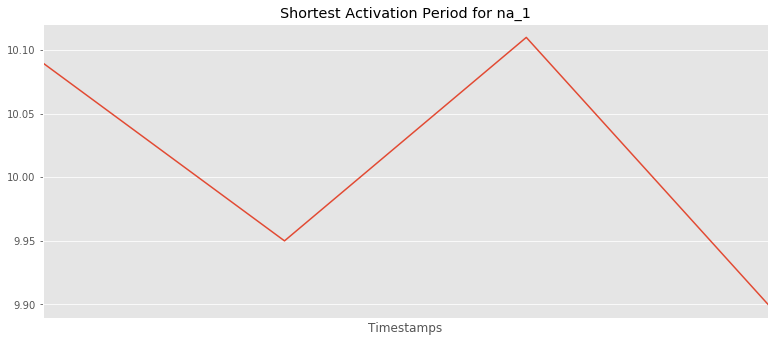

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514}


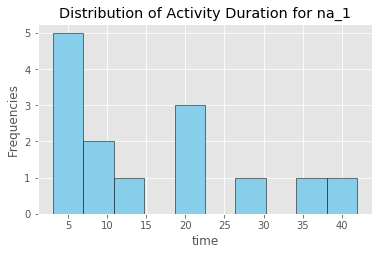

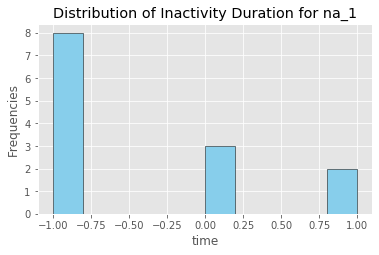

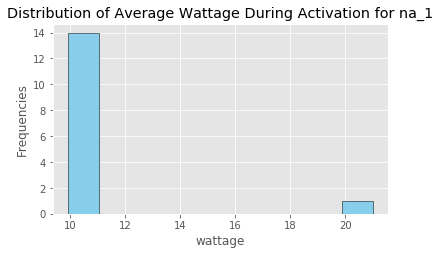

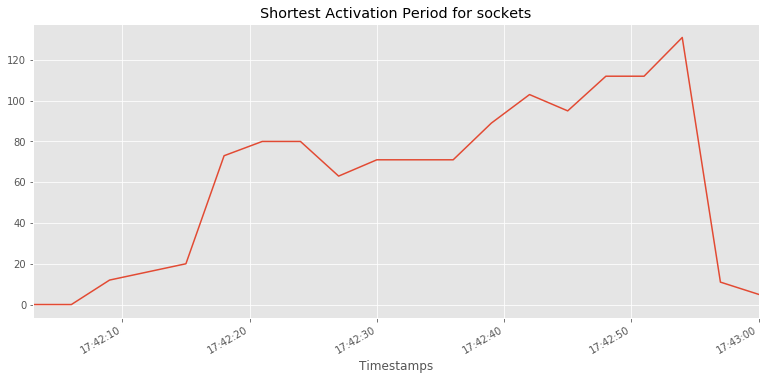

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524}


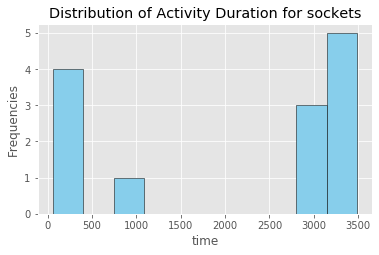

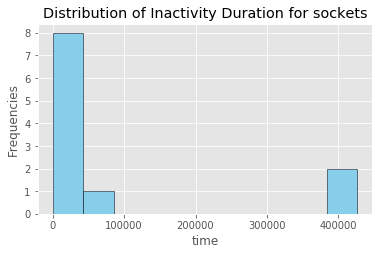

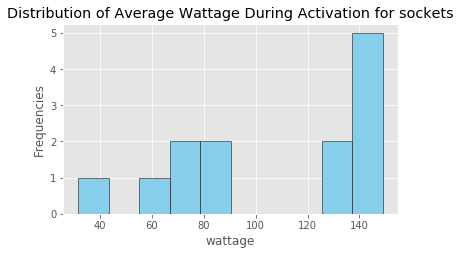

There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
Insufficient active periods to calculate gaps.
There are NO activation period for sockets_1.
{'na_1': 0.1180514, 'sockets': 89.10524}
There are NO activation period for sockets_1.


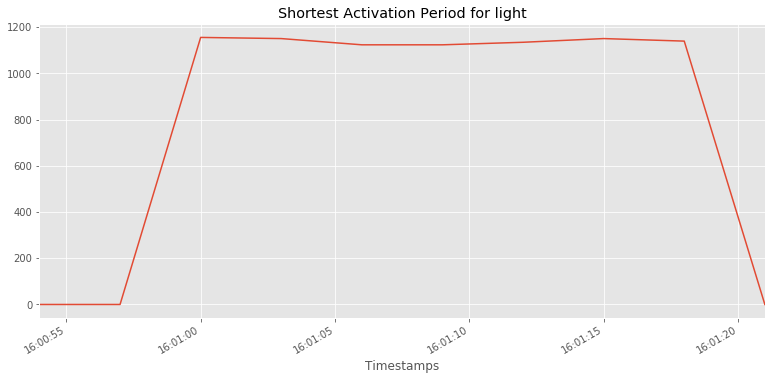

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214}


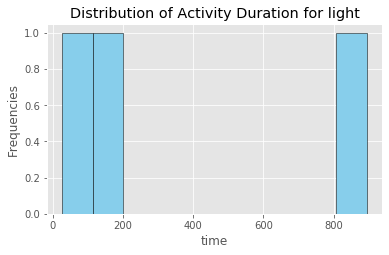

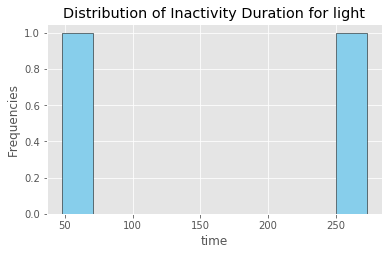

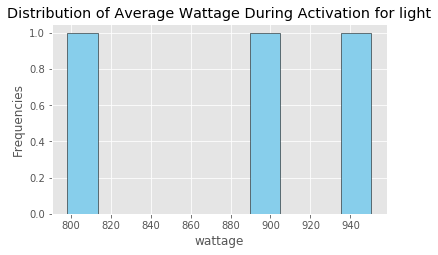

There are NO activation period for CE appliance.
There are NO activation period for CE appliance.
There are NO activation period for CE appliance.
There are NO activation period for CE appliance.
Insufficient active periods to calculate gaps.
There are NO activation period for CE appliance.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214}
There are NO activation period for CE appliance.


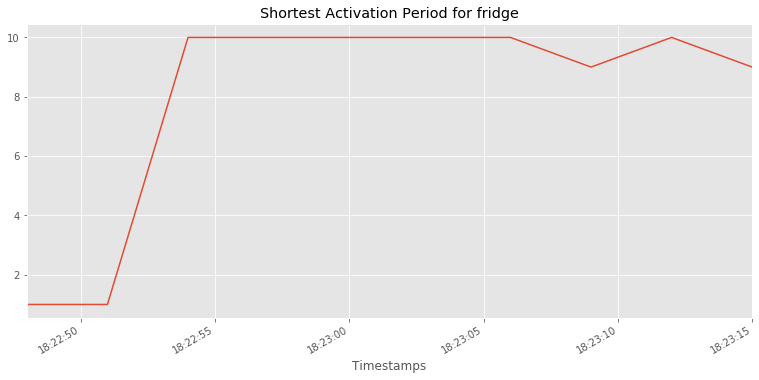

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369}


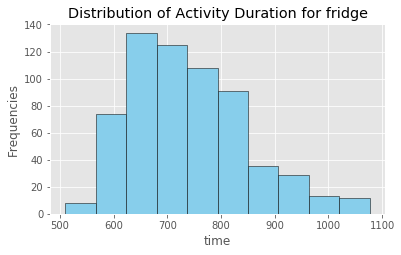

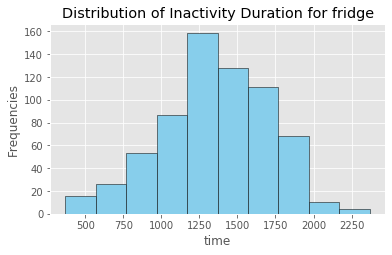

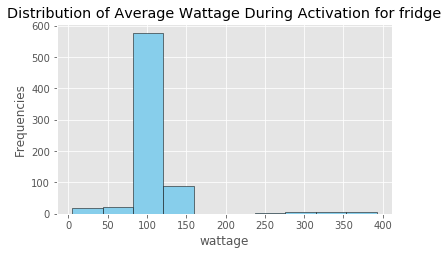

There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
Insufficient active periods to calculate gaps.
There are NO activation period for waste disposal unit.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369}
There are NO activation period for waste disposal unit.


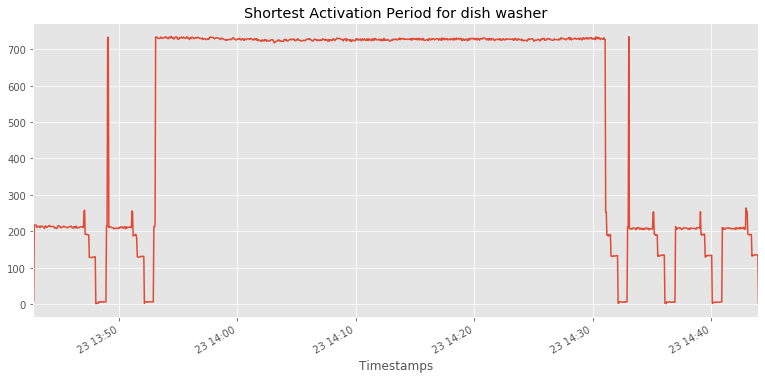

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263}


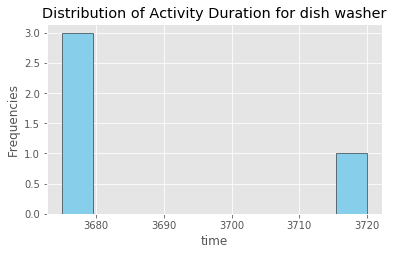

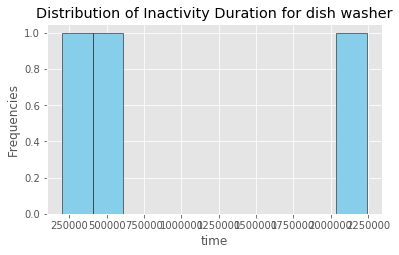

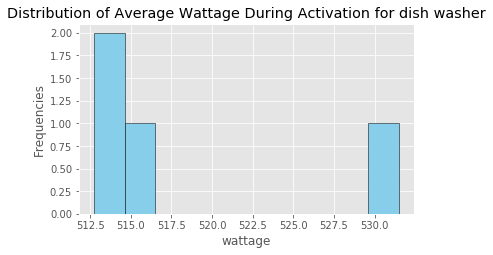

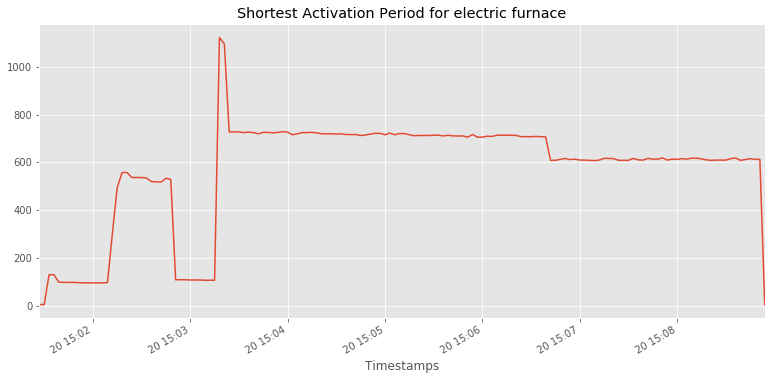

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606}


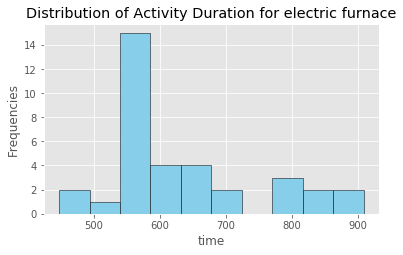

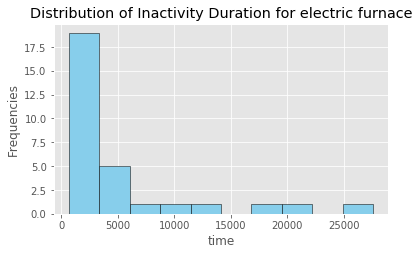

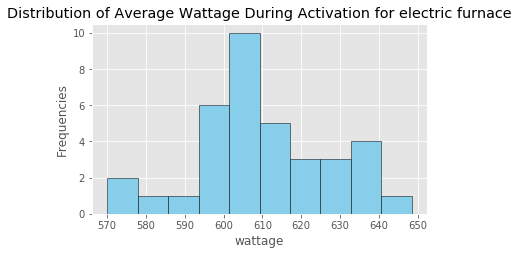

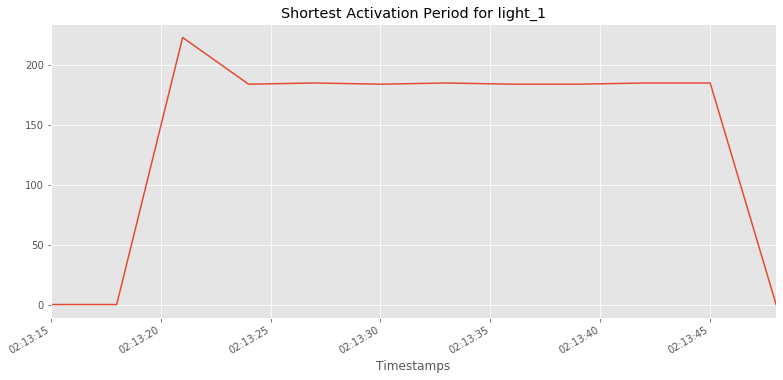

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587}


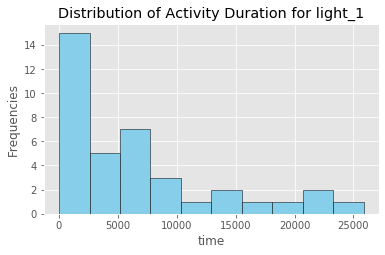

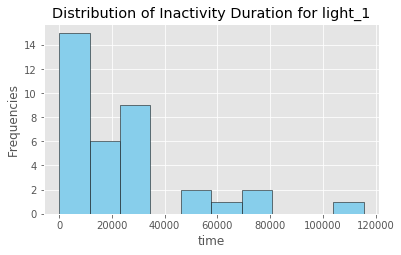

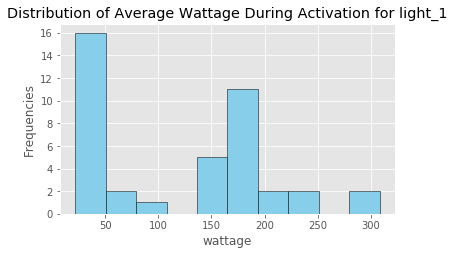

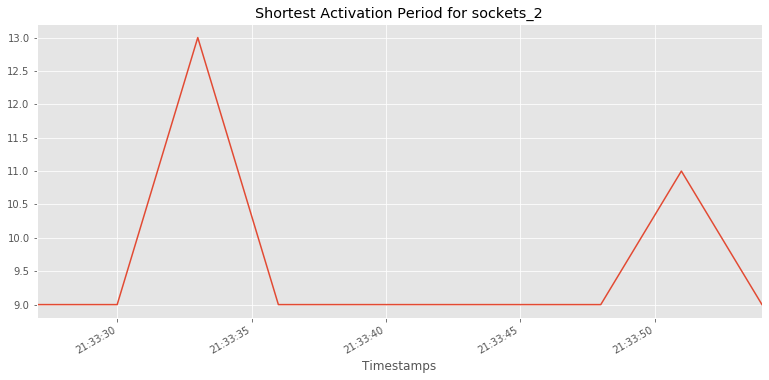

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281}


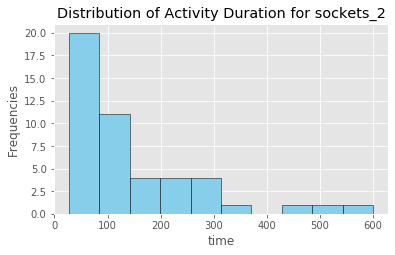

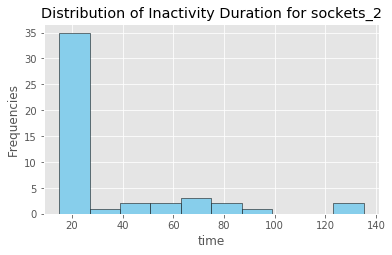

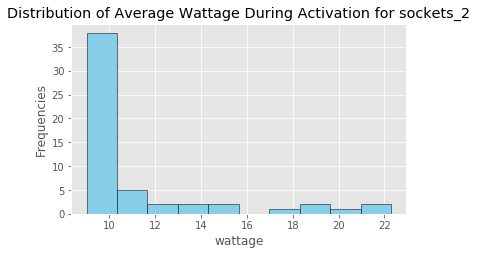

There are NO activation period for light_2.
There are NO activation period for light_2.
There are NO activation period for light_2.
There are NO activation period for light_2.
Insufficient active periods to calculate gaps.
There are NO activation period for light_2.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281}
There are NO activation period for light_2.


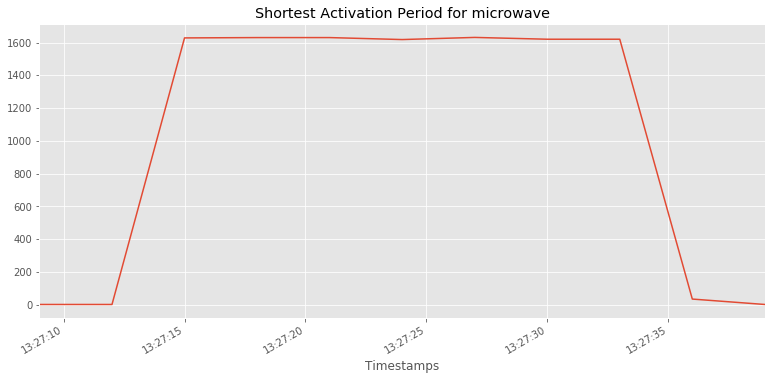

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463}


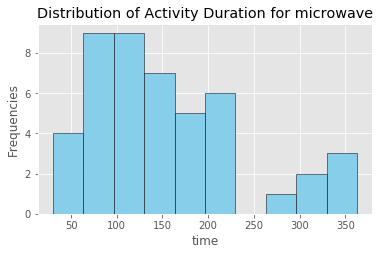

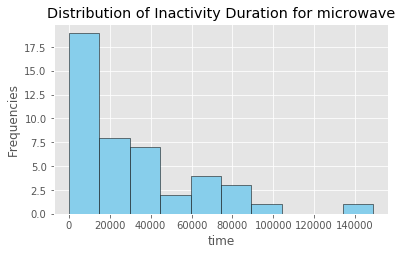

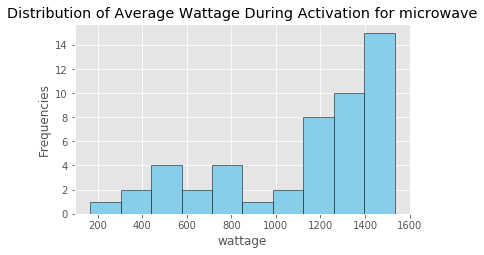

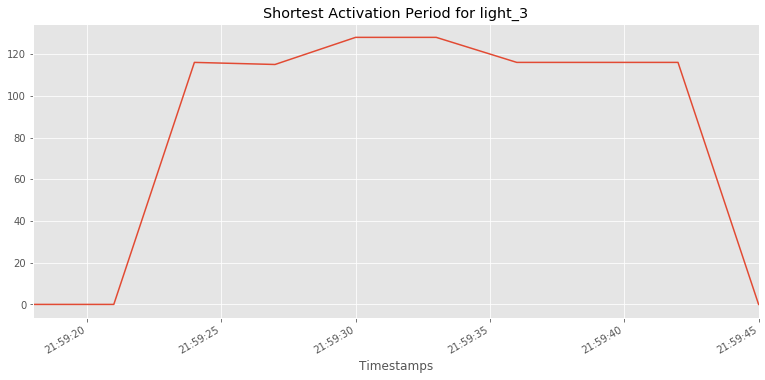

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463, 'light_3': 21.822445}


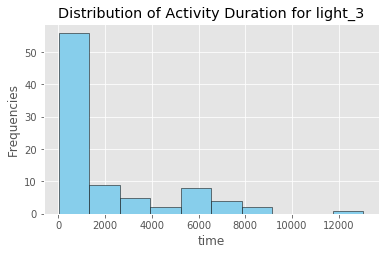

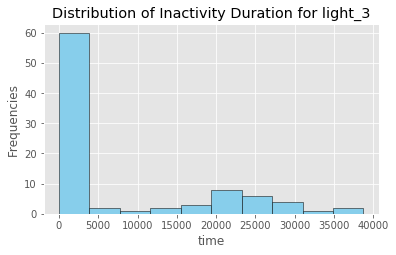

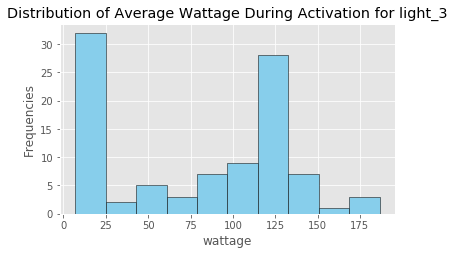

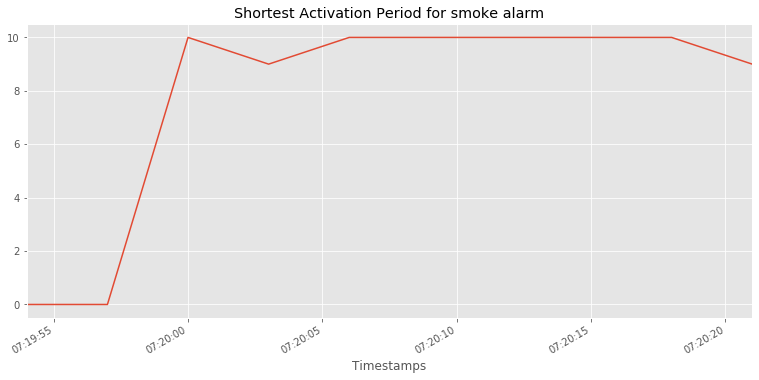

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463, 'light_3': 21.822445, 'smoke alarm': 2.3450296}


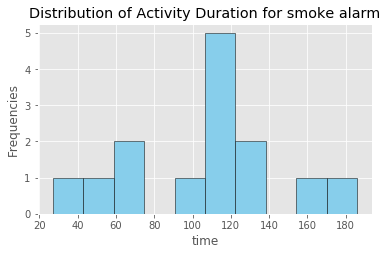

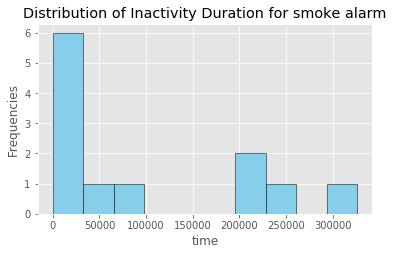

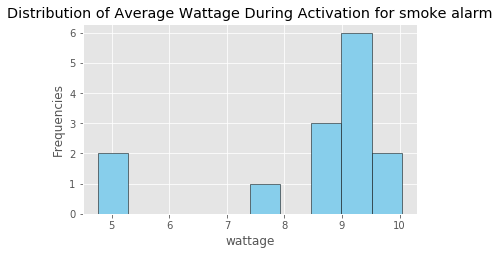

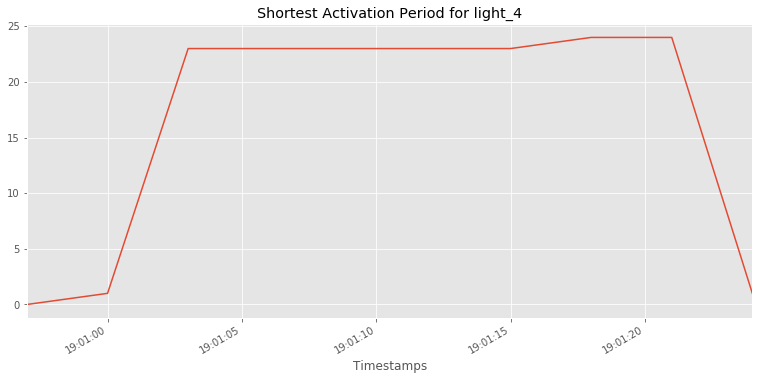

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463, 'light_3': 21.822445, 'smoke alarm': 2.3450296, 'light_4': 14.534049}


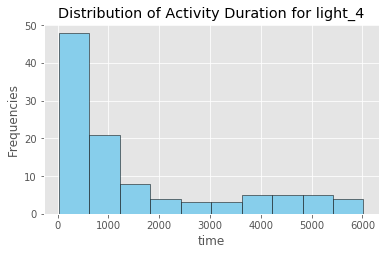

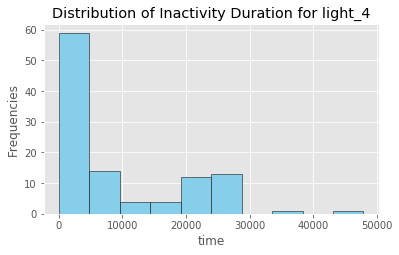

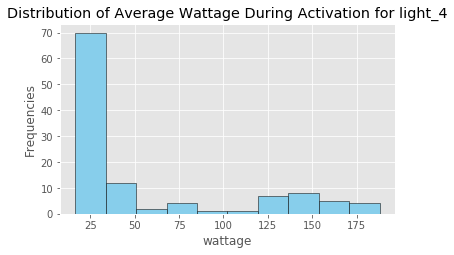

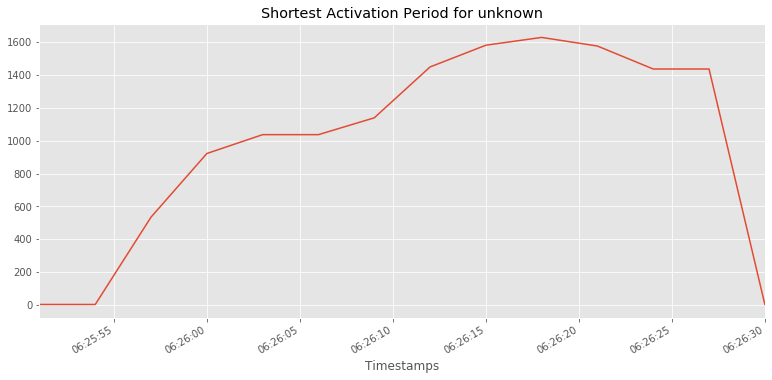

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463, 'light_3': 21.822445, 'smoke alarm': 2.3450296, 'light_4': 14.534049, 'unknown': 362.80466}


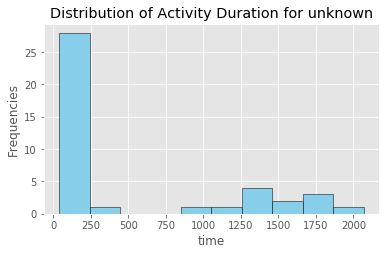

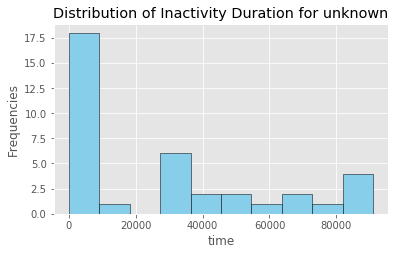

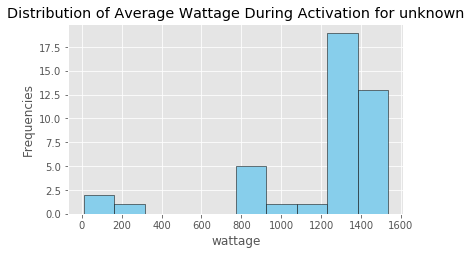

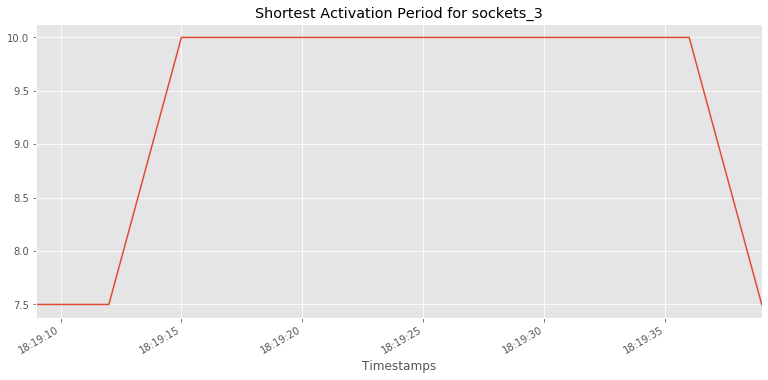

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463, 'light_3': 21.822445, 'smoke alarm': 2.3450296, 'light_4': 14.534049, 'unknown': 362.80466, 'sockets_3': 2.4202218}


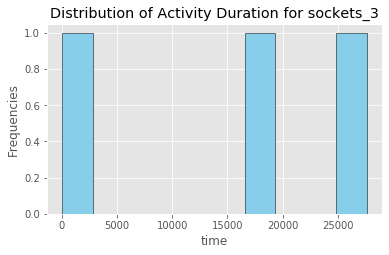

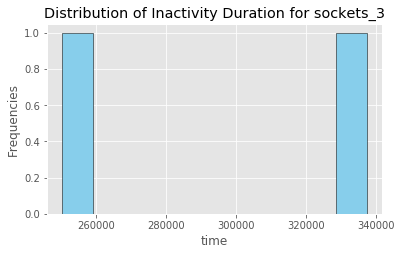

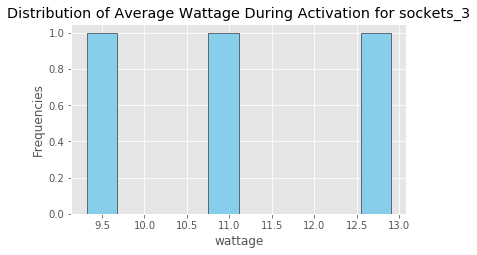

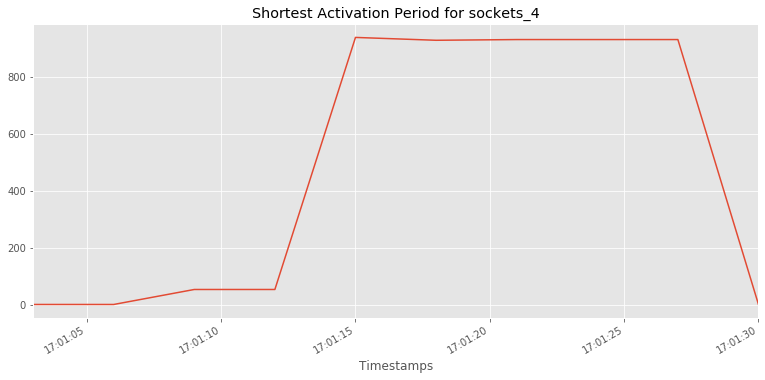

SUCCESS! Exported the longest ap and shortest ap plots.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463, 'light_3': 21.822445, 'smoke alarm': 2.3450296, 'light_4': 14.534049, 'unknown': 362.80466, 'sockets_3': 2.4202218, 'sockets_4': 228.63853}


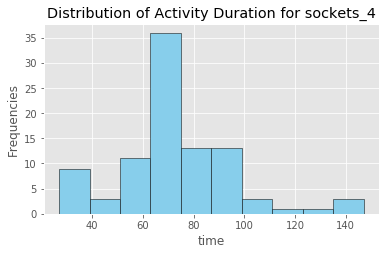

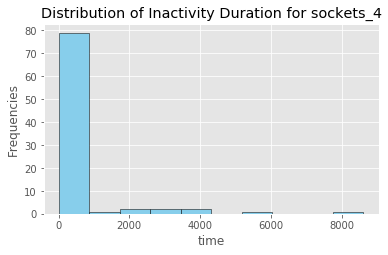

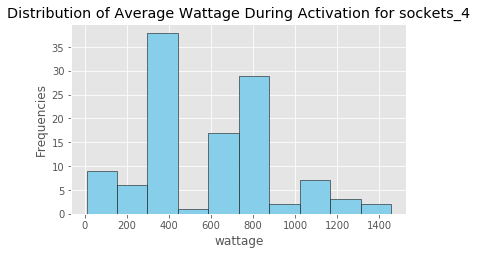

Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


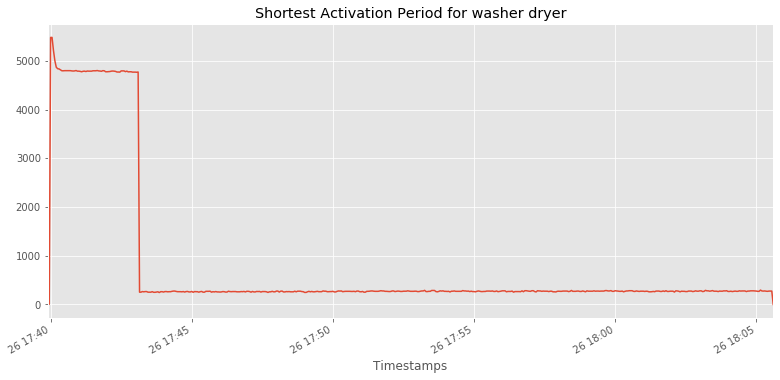

SUCCESS! Exported the longest ap and shortest ap plots.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
{'na_1': 0.1180514, 'sockets': 89.10524, 'light': 282.32214, 'fridge': 14.683369, 'dish washer': 284.69263, 'electric furnace': 198.8606, 'light_1': 33.432587, 'sockets_2': 1.7747281, 'microwave': 701.6463, 'light_3': 21.822445, 'smoke alarm': 2.3450296, 'light_4': 14.534049, 'unknown': 362.80466, 'sockets_3': 2.

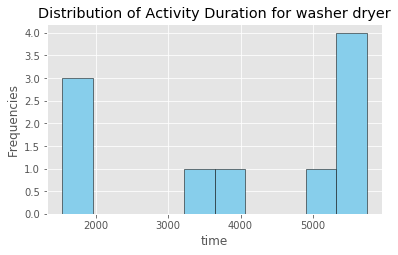

Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


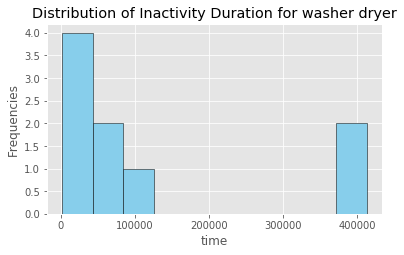

Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


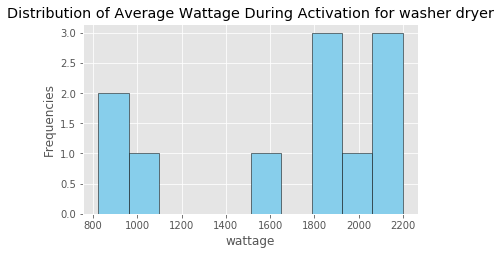

Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


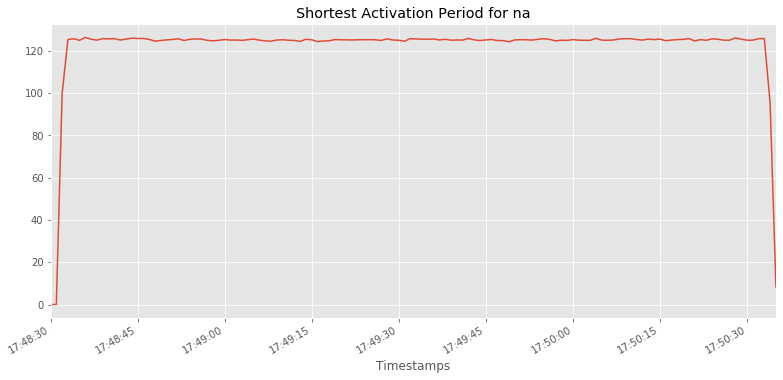

SUCCESS! Exported the longest ap and shortest ap plots.
Insufficient active periods to calculate gaps.
{'na': 18.935959}


<Figure size 936x432 with 0 Axes>

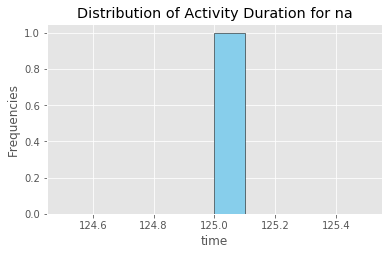

Insufficient active periods to calculate gaps.


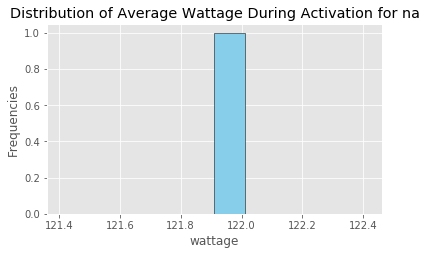

Not enough data points to generate variance.


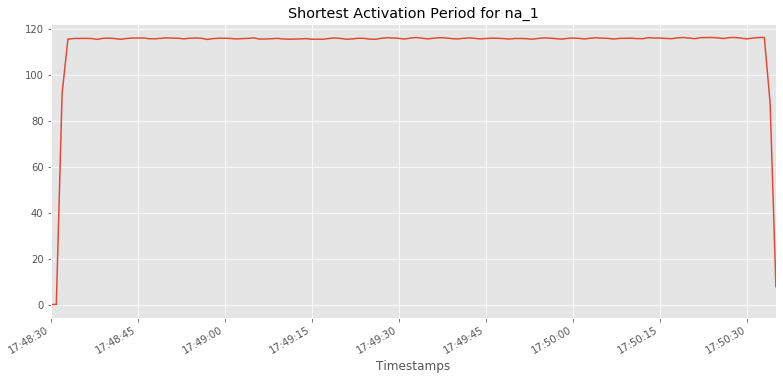

SUCCESS! Exported the longest ap and shortest ap plots.
Insufficient active periods to calculate gaps.
{'na': 18.935959, 'na_1': 17.515638}


<Figure size 936x432 with 0 Axes>

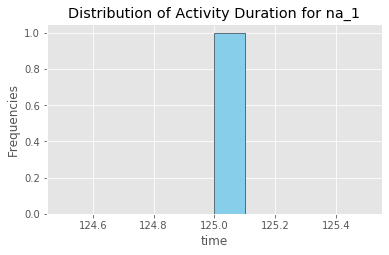

Insufficient active periods to calculate gaps.


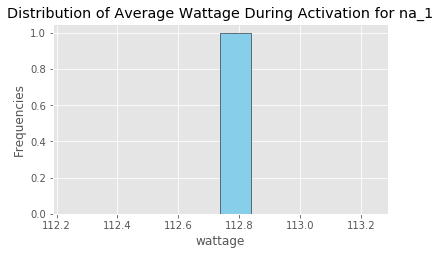

Not enough data points to generate variance.


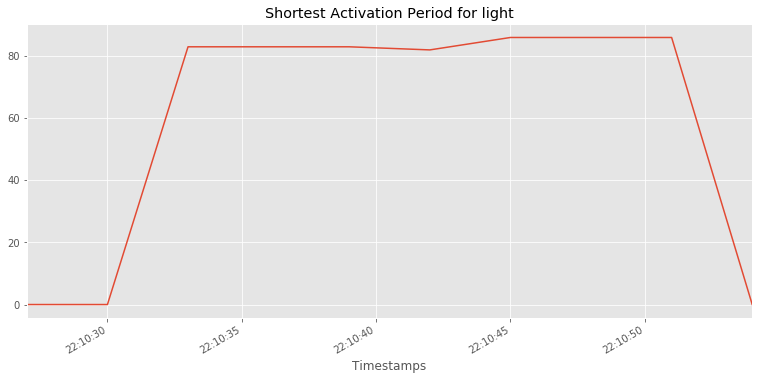

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568}


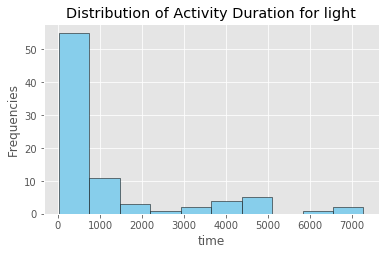

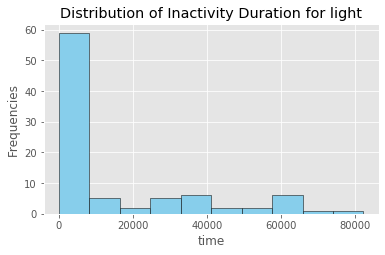

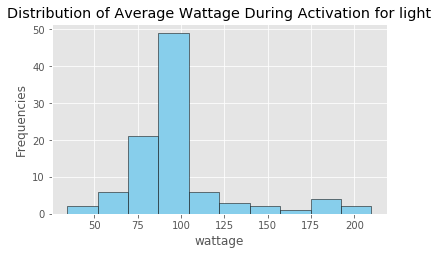

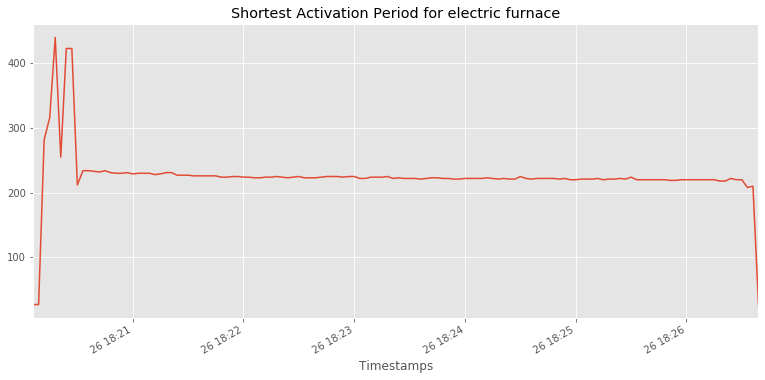

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747}


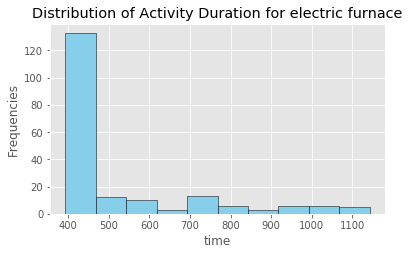

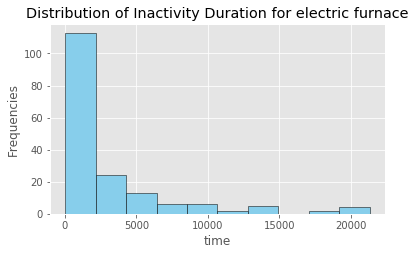

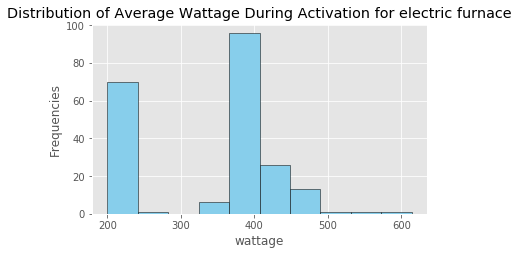

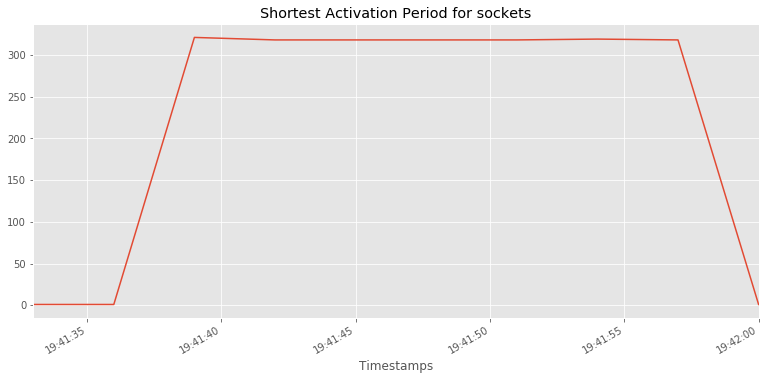

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224}


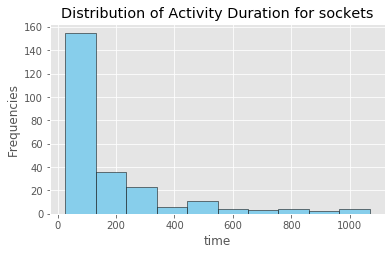

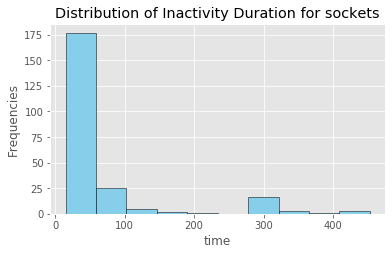

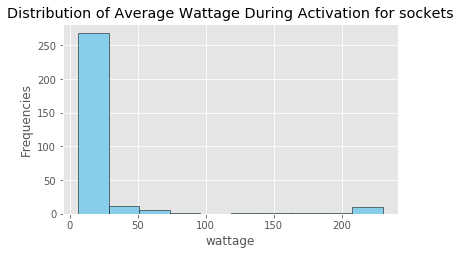

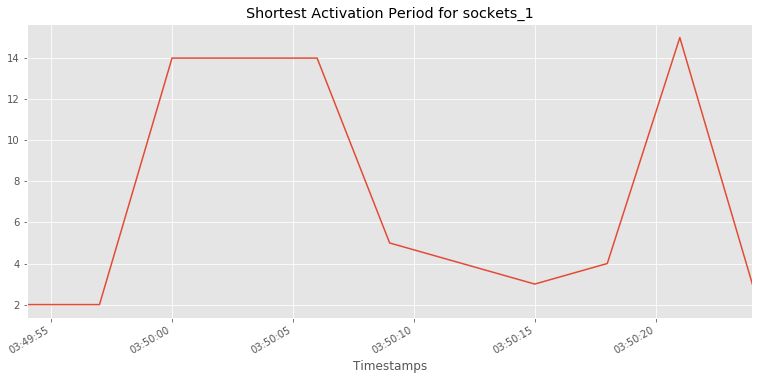

SUCCESS! Exported the longest ap and shortest ap plots.
Insufficient active periods to calculate gaps.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413}


<Figure size 936x432 with 0 Axes>

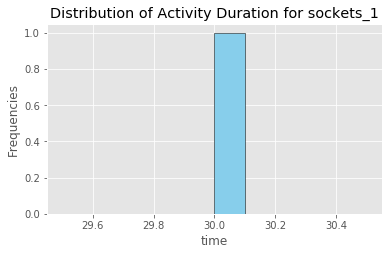

Insufficient active periods to calculate gaps.


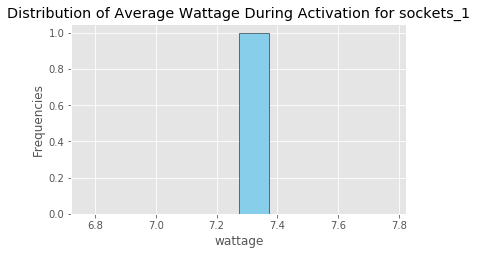

Not enough data points to generate variance.


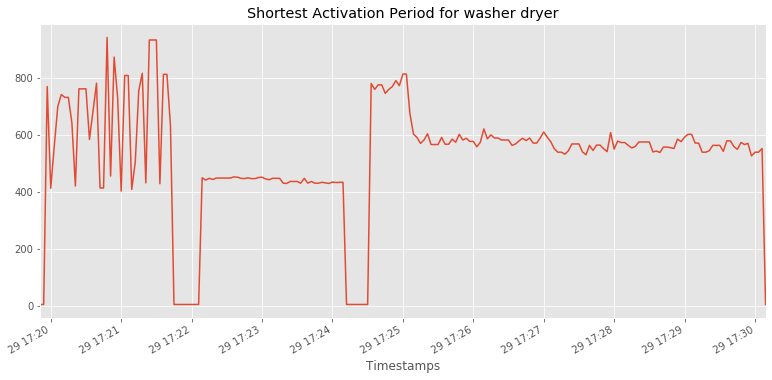

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991}


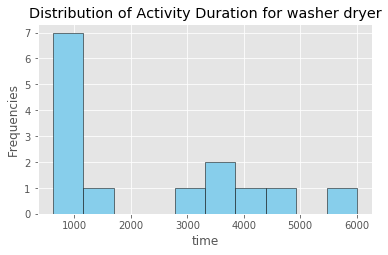

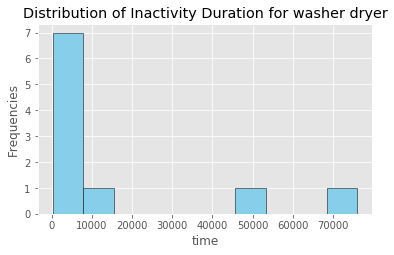

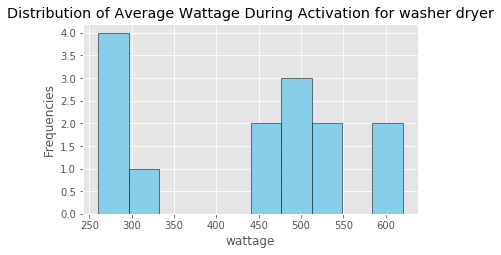

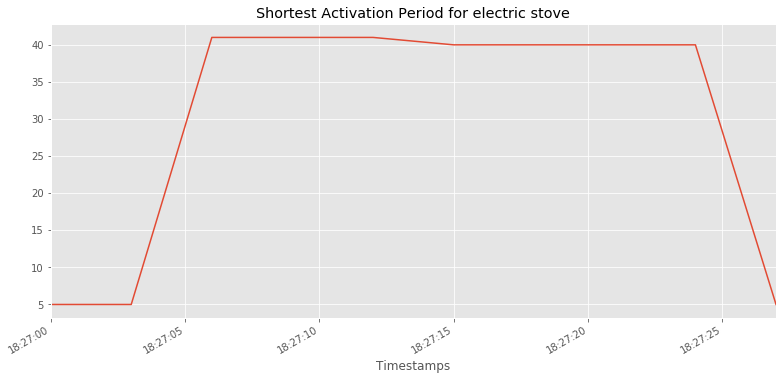

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698}


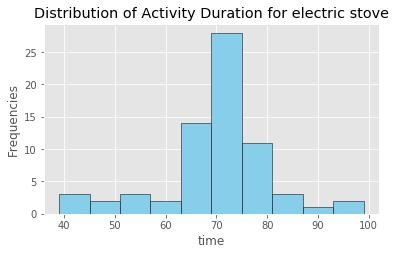

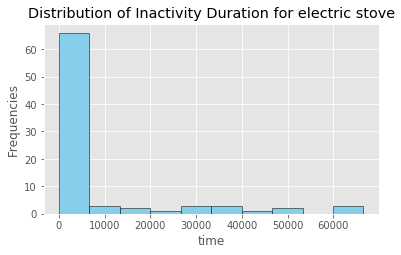

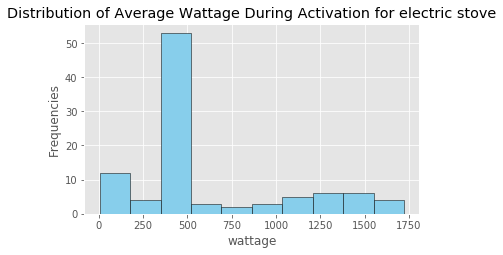

There are NO activation period for unknown.
There are NO activation period for unknown.
There are NO activation period for unknown.
There are NO activation period for unknown.
Insufficient active periods to calculate gaps.
There are NO activation period for unknown.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698}
There are NO activation period for unknown.
There are NO activation period for smoke alarm.
There are NO activation period for smoke alarm.
There are NO activation period for smoke alarm.
There are NO activation period for smoke alarm.
Insufficient active periods to calculate gaps.
There are NO activation period for smoke alarm.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698}
There are NO activatio

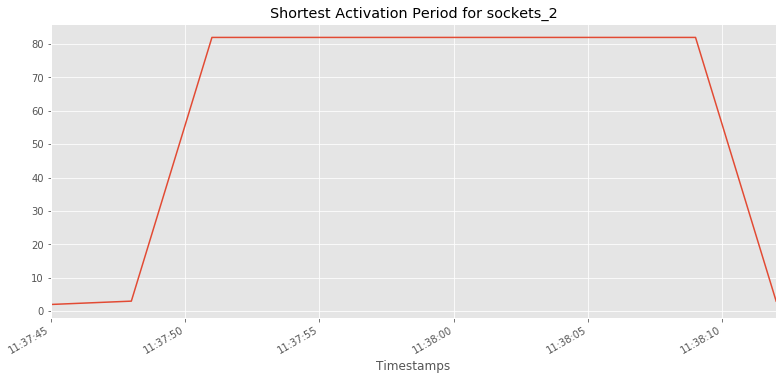

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956}


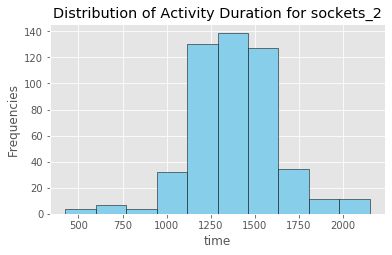

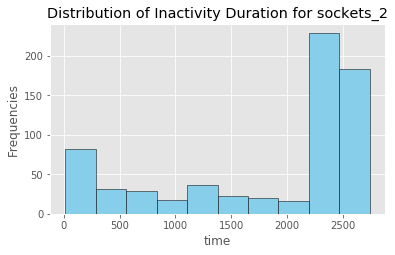

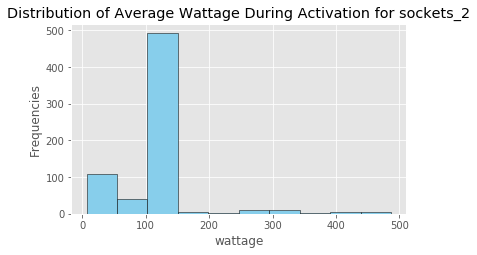

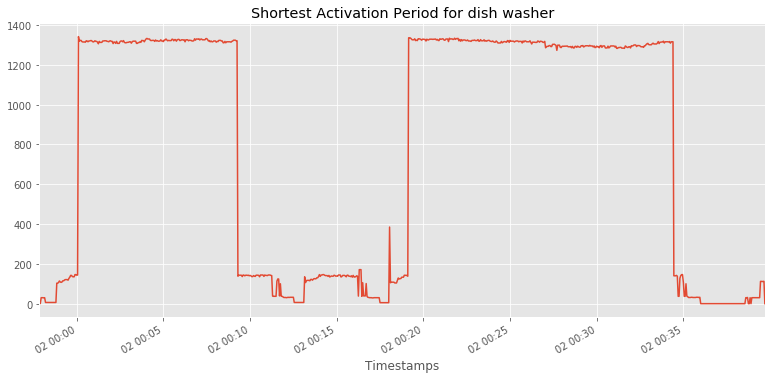

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956, 'dish washer': 619.825}


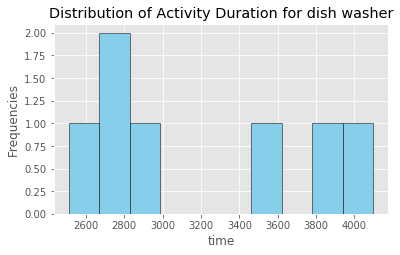

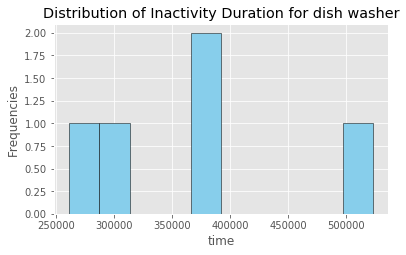

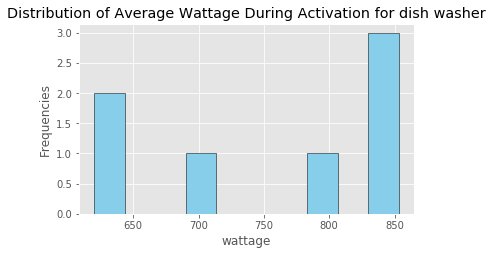

There are NO activation period for unknown_1.
There are NO activation period for unknown_1.
There are NO activation period for unknown_1.
There are NO activation period for unknown_1.
Insufficient active periods to calculate gaps.
There are NO activation period for unknown_1.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956, 'dish washer': 619.825}
There are NO activation period for unknown_1.


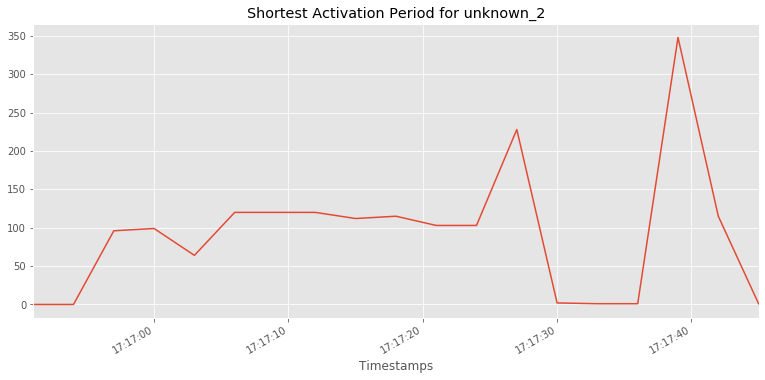

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956, 'dish washer': 619.825, 'unknown_2': 128.477}


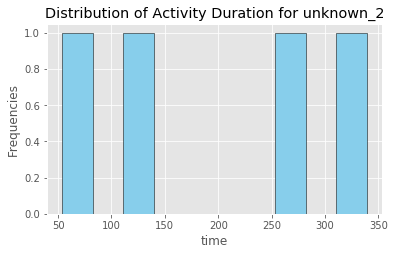

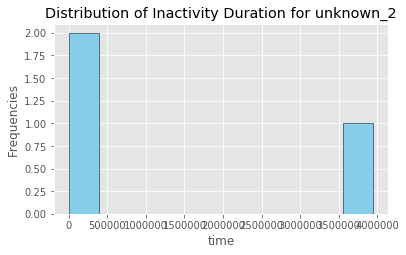

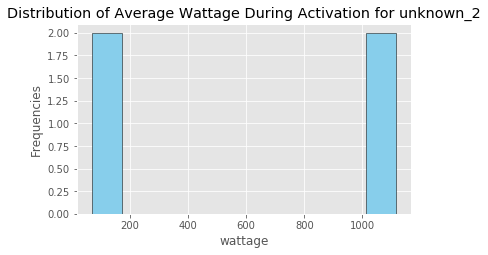

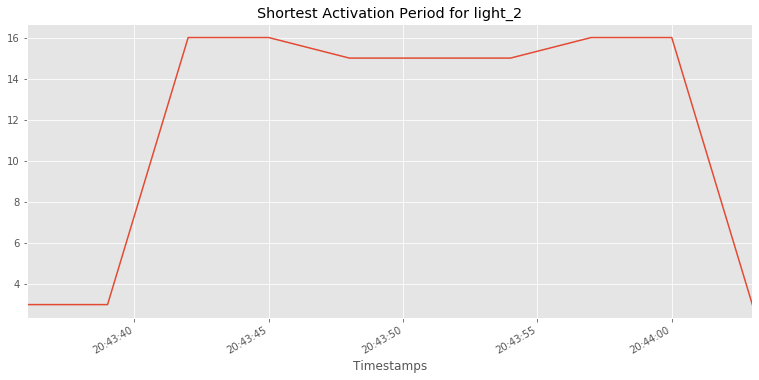

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956, 'dish washer': 619.825, 'unknown_2': 128.477, 'light_2': 3.6395695}


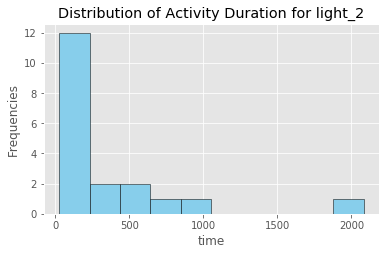

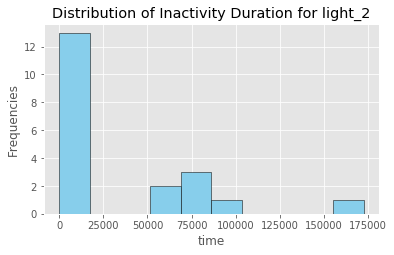

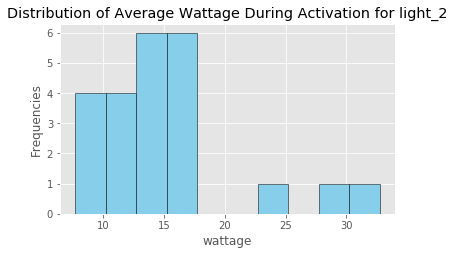

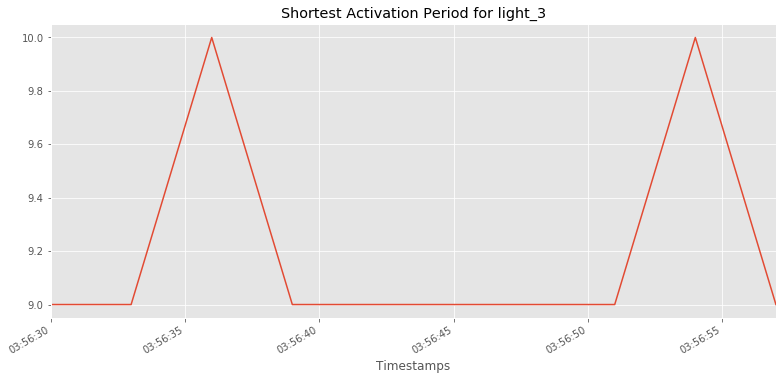

SUCCESS! Exported the longest ap and shortest ap plots.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956, 'dish washer': 619.825, 'unknown_2': 128.477, 'light_2': 3.6395695, 'light_3': 4.8442936}


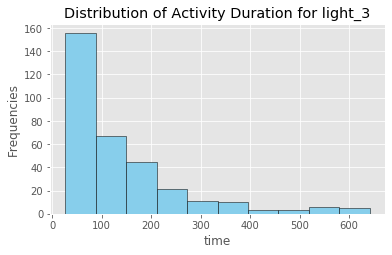

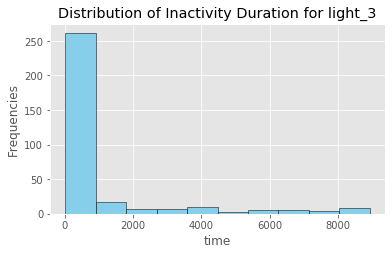

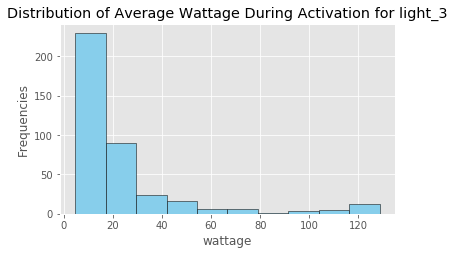

There are NO activation period for air conditioner.
There are NO activation period for air conditioner.
There are NO activation period for air conditioner.
There are NO activation period for air conditioner.
Insufficient active periods to calculate gaps.
There are NO activation period for air conditioner.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956, 'dish washer': 619.825, 'unknown_2': 128.477, 'light_2': 3.6395695, 'light_3': 4.8442936}
There are NO activation period for air conditioner.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done 

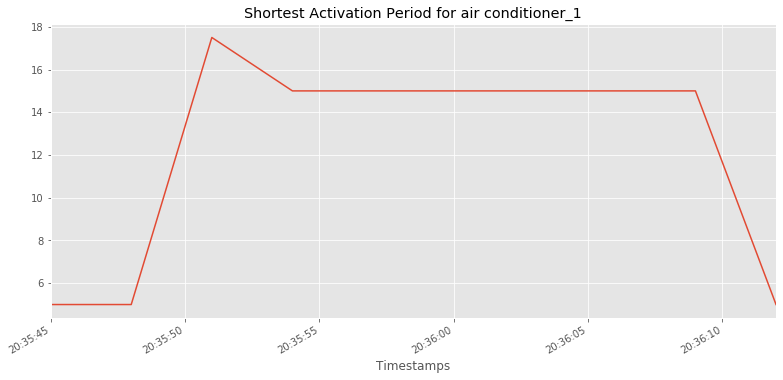

SUCCESS! Exported the longest ap and shortest ap plots.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
{'na': 18.935959, 'na_1': 17.515638, 'light': 26.734568, 'electric furnace': 127.93747, 'sockets': 3.7983224, 'sockets_1': 5.3443413, 'washer dryer': 185.13991, 'electric stove': 345.62698, 'sockets_2': 15.77956, 'dish washer': 619.825, 'unknown_2': 128.477, 'light_2': 3.6395695, 'light_3': 4.8442936, 'air condit

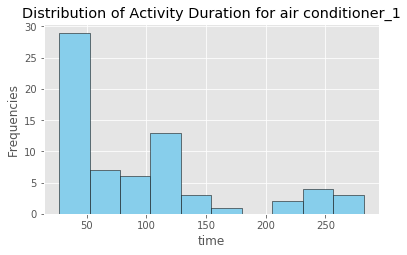

Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.


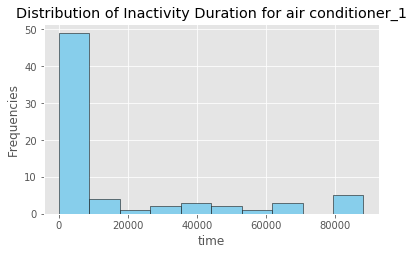

Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.


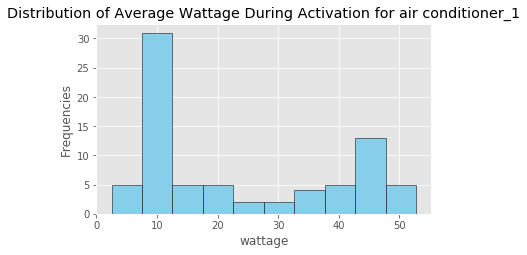

Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
Insufficient active periods to calculate gaps.
There are NO activation period for na.
{}
There are NO activation period for na.
There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
Insufficient active periods to calculate gaps.
There are NO activation period for na_1.
{}
There are NO activation period for na_1.


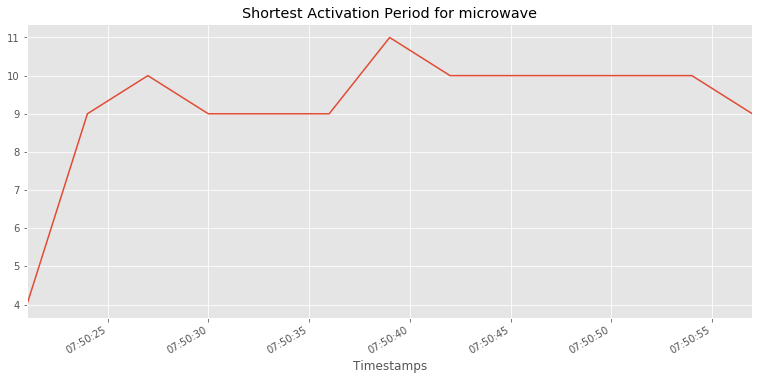

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016}


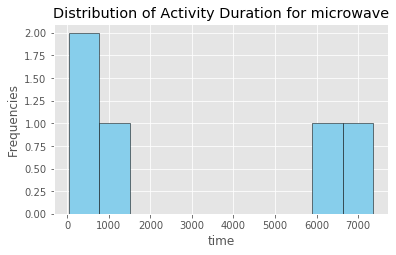

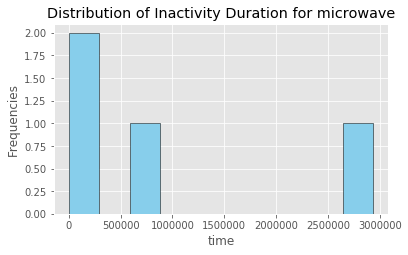

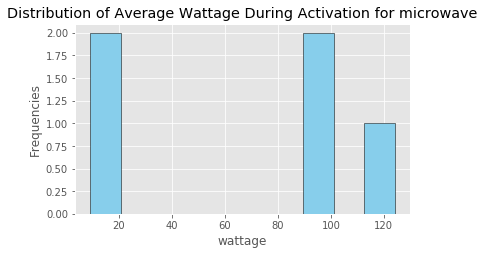

There are NO activation period for light.
There are NO activation period for light.
There are NO activation period for light.
There are NO activation period for light.
Insufficient active periods to calculate gaps.
There are NO activation period for light.
{'microwave': 3.4706016}
There are NO activation period for light.


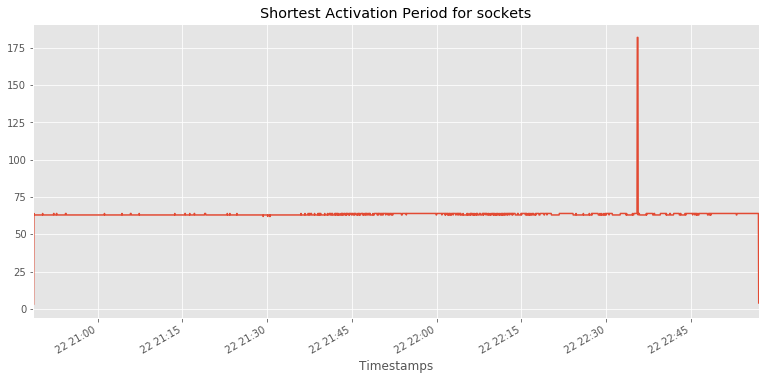

SUCCESS! Exported the longest ap and shortest ap plots.
Insufficient active periods to calculate gaps.
{'microwave': 3.4706016, 'sockets': 4.568219}


<Figure size 936x432 with 0 Axes>

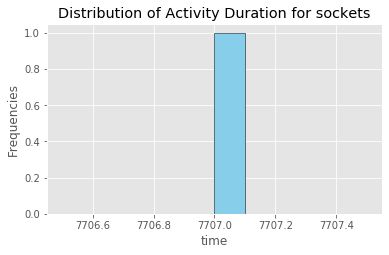

Insufficient active periods to calculate gaps.


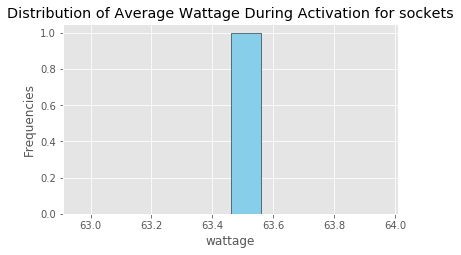

Not enough data points to generate variance.


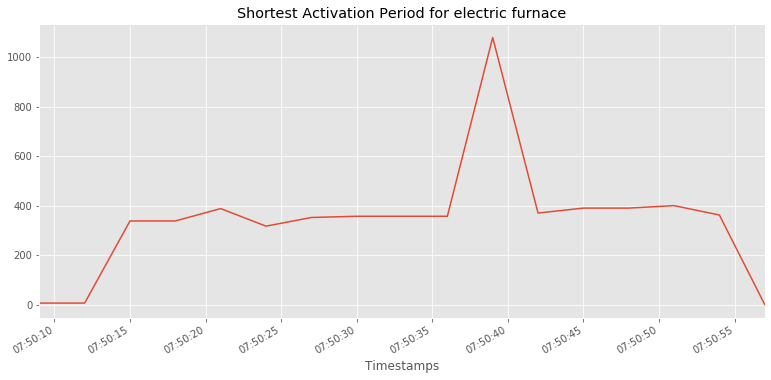

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187}


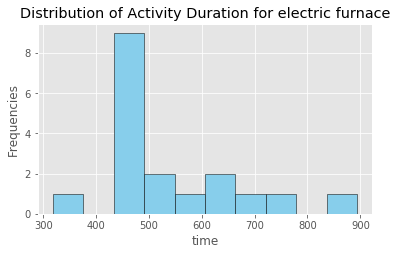

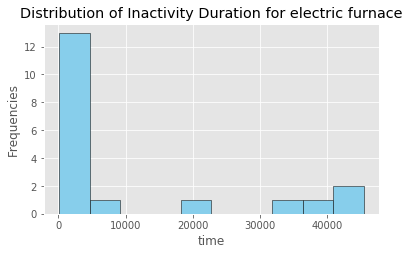

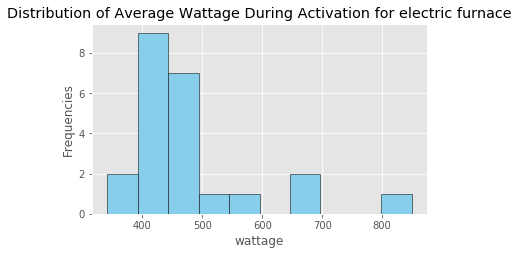

There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
There are NO activation period for sockets_1.
Insufficient active periods to calculate gaps.
There are NO activation period for sockets_1.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187}
There are NO activation period for sockets_1.
There are NO activation period for subpanel.
There are NO activation period for subpanel.
There are NO activation period for subpanel.
There are NO activation period for subpanel.
Insufficient active periods to calculate gaps.
There are NO activation period for subpanel.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187}
There are NO activation period for subpanel.


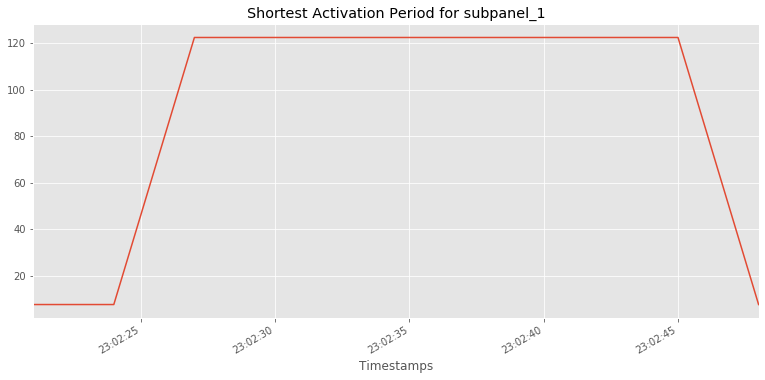

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064}


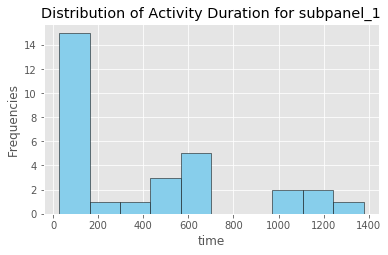

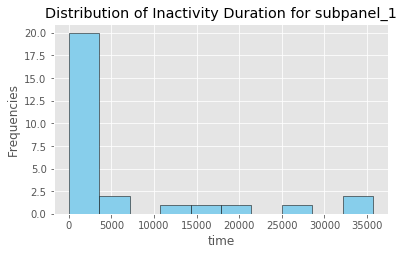

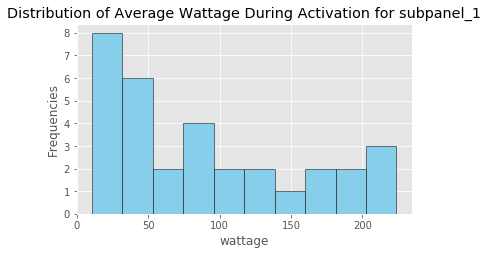

There are NO activation period for light_1.
There are NO activation period for light_1.
There are NO activation period for light_1.
There are NO activation period for light_1.
Insufficient active periods to calculate gaps.
There are NO activation period for light_1.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064}
There are NO activation period for light_1.
There are NO activation period for sockets_2.
There are NO activation period for sockets_2.
There are NO activation period for sockets_2.
There are NO activation period for sockets_2.
Insufficient active periods to calculate gaps.
There are NO activation period for sockets_2.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064}
There are NO activation period for sockets_2.


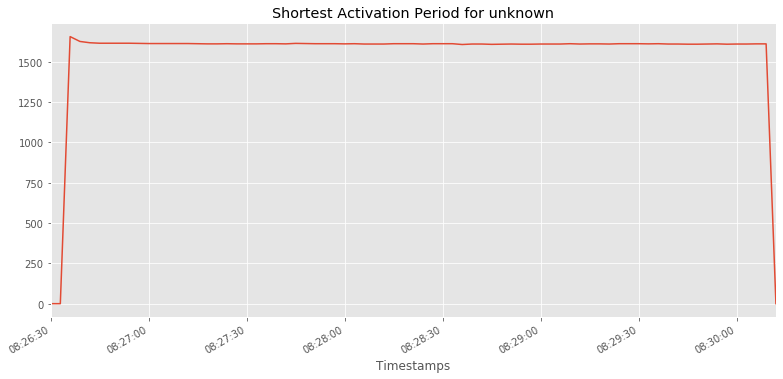

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932}


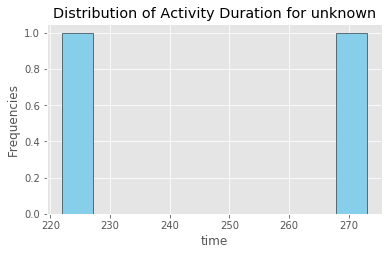

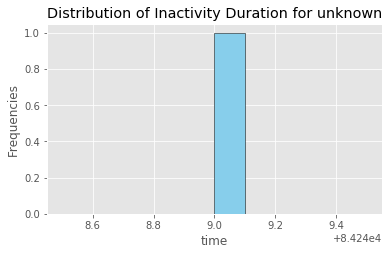

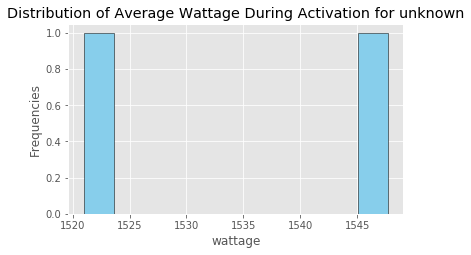

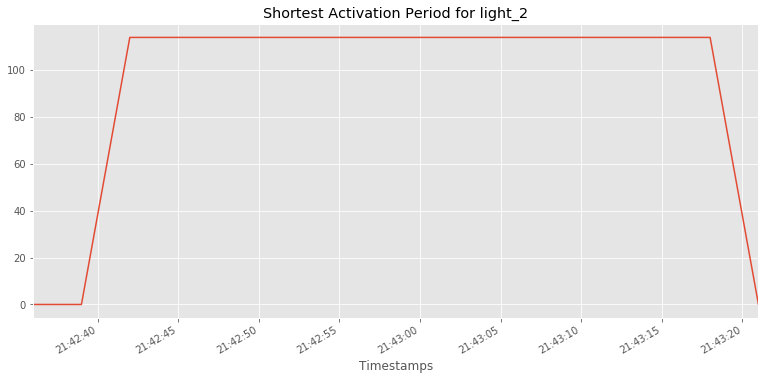

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202}


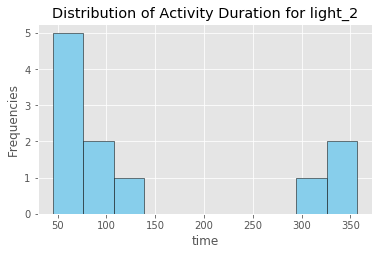

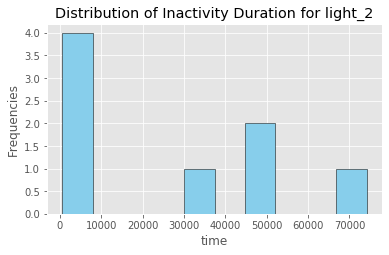

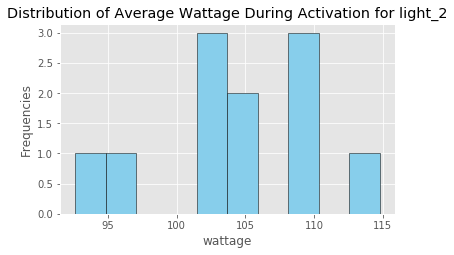

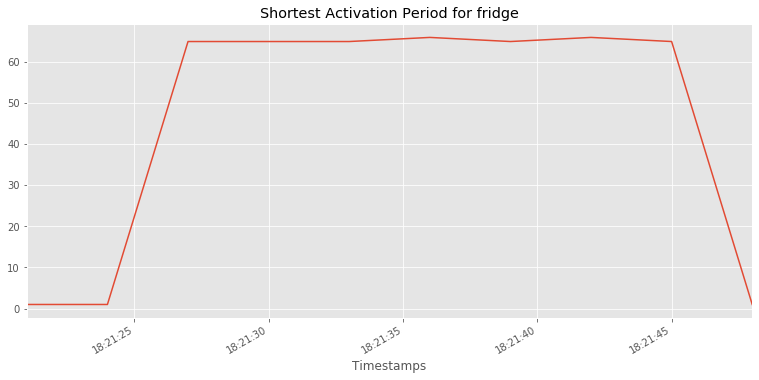

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052}


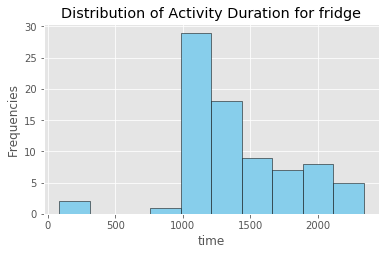

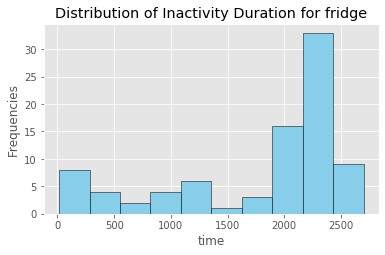

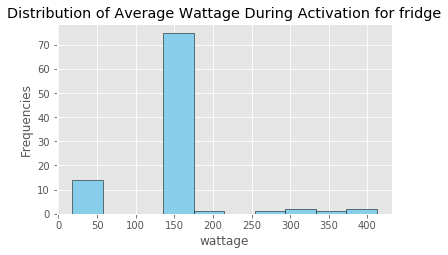

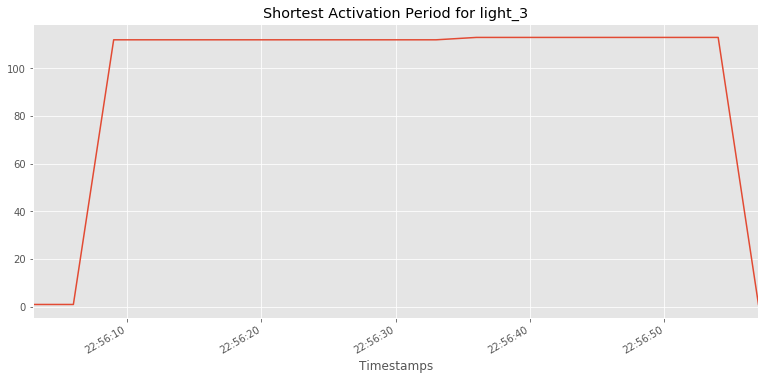

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633}


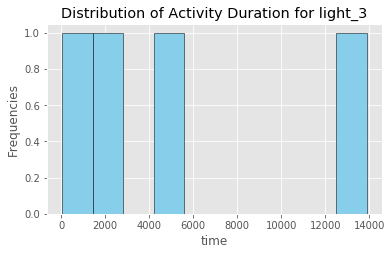

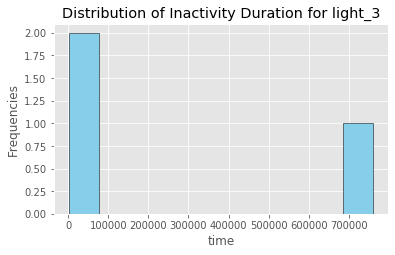

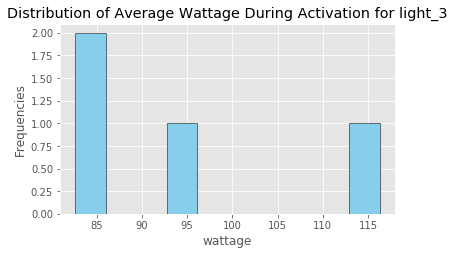

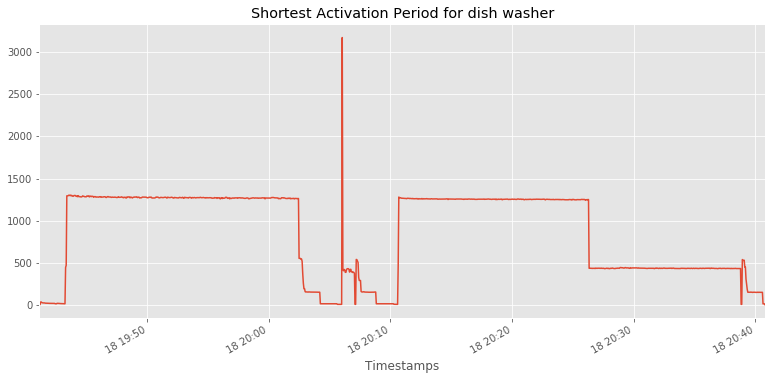

SUCCESS! Exported the longest ap and shortest ap plots.
Insufficient active periods to calculate gaps.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633, 'dish washer': 503.24963}


<Figure size 936x432 with 0 Axes>

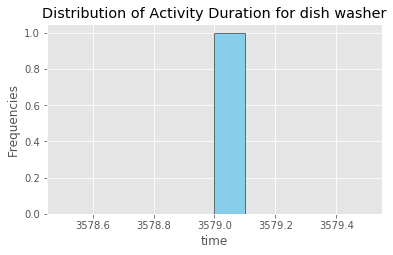

Insufficient active periods to calculate gaps.


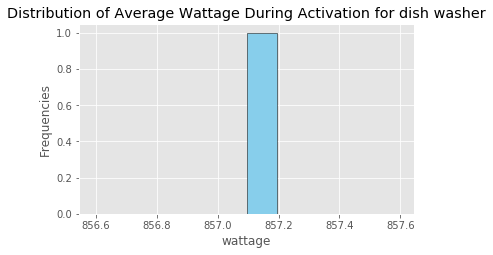

Not enough data points to generate variance.
There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
There are NO activation period for waste disposal unit.
Insufficient active periods to calculate gaps.
There are NO activation period for waste disposal unit.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633, 'dish washer': 503.24963}
There are NO activation period for waste disposal unit.


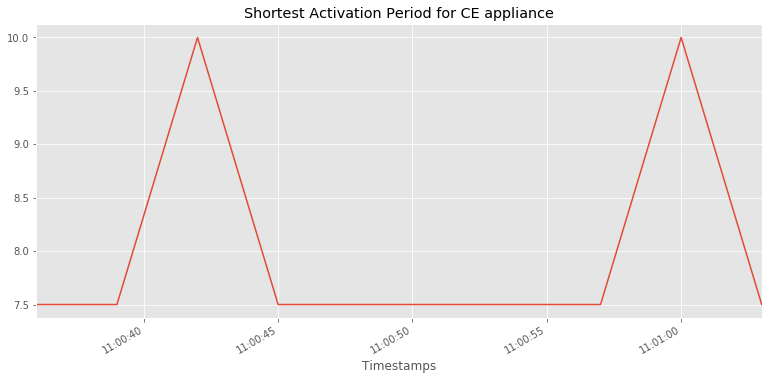

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633, 'dish washer': 503.24963, 'CE appliance': 1.174395}


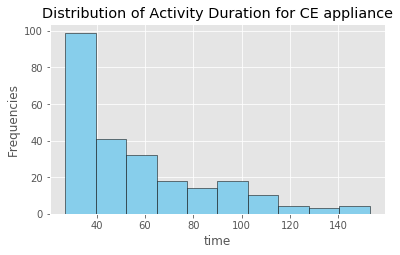

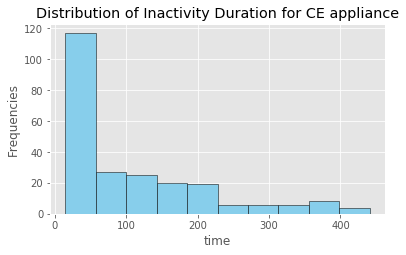

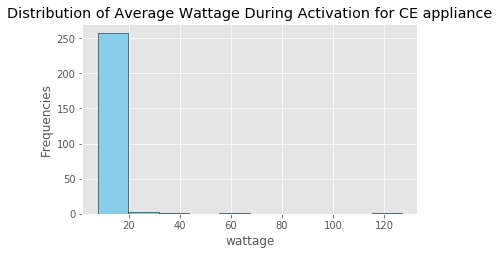

There are NO activation period for light_4.
There are NO activation period for light_4.
There are NO activation period for light_4.
There are NO activation period for light_4.
Insufficient active periods to calculate gaps.
There are NO activation period for light_4.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633, 'dish washer': 503.24963, 'CE appliance': 1.174395}
There are NO activation period for light_4.


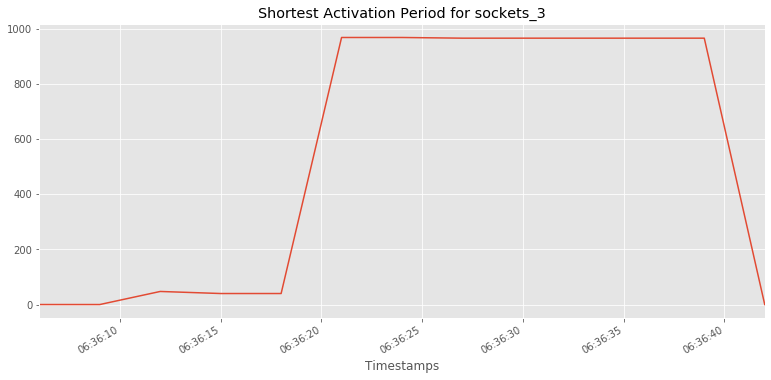

SUCCESS! Exported the longest ap and shortest ap plots.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633, 'dish washer': 503.24963, 'CE appliance': 1.174395, 'sockets_3': 336.63196}


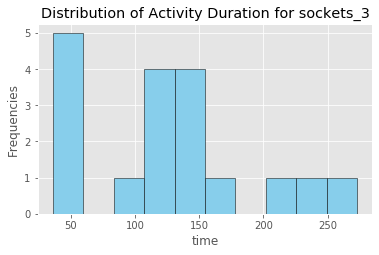

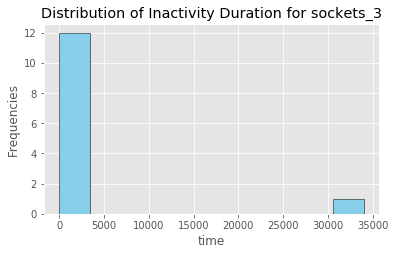

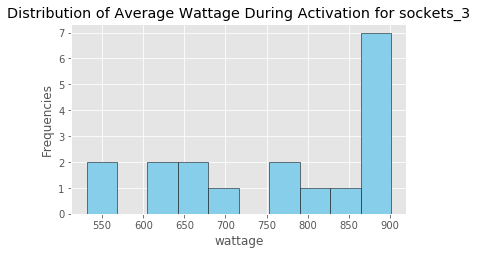

There are NO activation period for sockets_4.
There are NO activation period for sockets_4.
There are NO activation period for sockets_4.
There are NO activation period for sockets_4.
Insufficient active periods to calculate gaps.
There are NO activation period for sockets_4.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633, 'dish washer': 503.24963, 'CE appliance': 1.174395, 'sockets_3': 336.63196}
There are NO activation period for sockets_4.
There are NO activation period for sockets_5.
There are NO activation period for sockets_5.
There are NO activation period for sockets_5.
There are NO activation period for sockets_5.
Insufficient active periods to calculate gaps.
There are NO activation period for sockets_5.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33

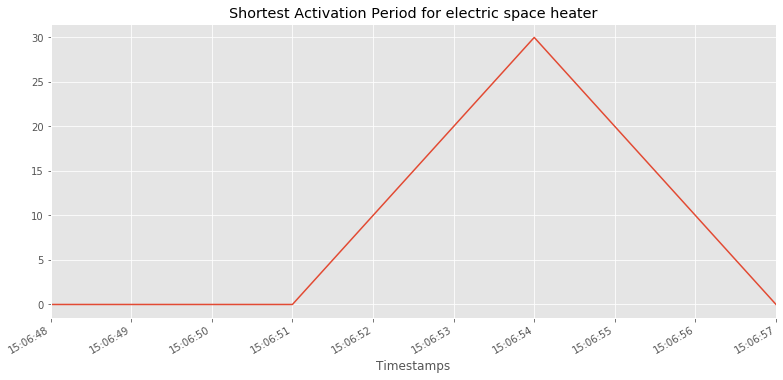

SUCCESS! Exported the longest ap and shortest ap plots.
Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
{'microwave': 3.4706016, 'sockets': 4.568219, 'electric furnace': 164.46187, 'subpanel_1': 27.376064, 'unknown': 340.0932, 'light_2': 33.674202, 'fridge': 17.951052, 'light_3': 13.411633, 'dish washer': 503.24963, 'CE appliance': 1.174395, 'sockets_3': 336.63196, 'electric space heater': 6.4734306}


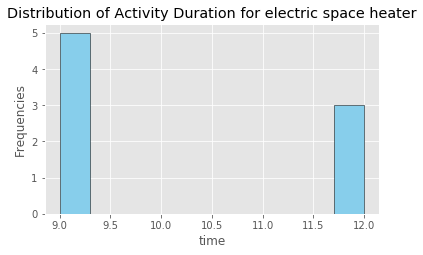

Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.


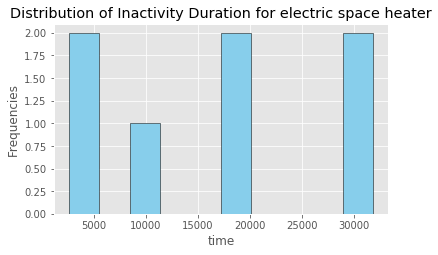

Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.


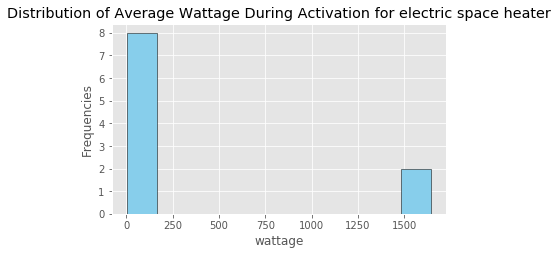

Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
There are NO activation period for na.
Insufficient active periods to calculate gaps.
There are NO activation period for na.
{}
There are NO activation period for na.
There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
There are NO activation period for na_1.
Insufficient active periods to calculate gaps.
There are NO activation period for na_1.
{}
There are NO activation period for na_1.


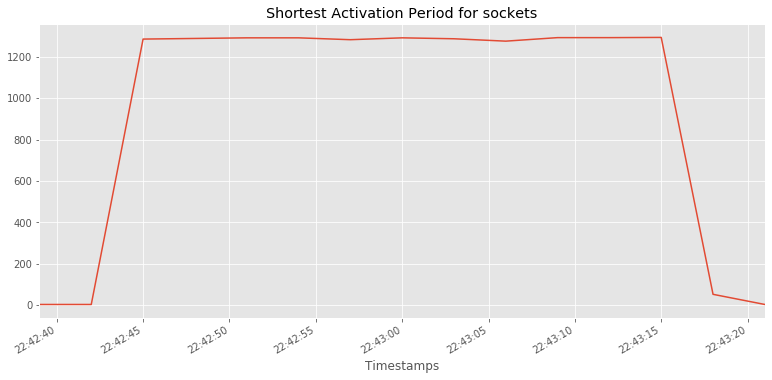

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846}


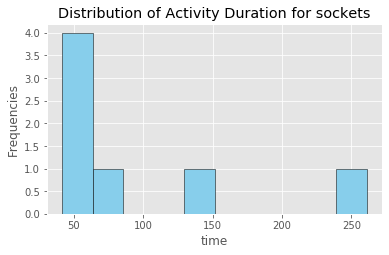

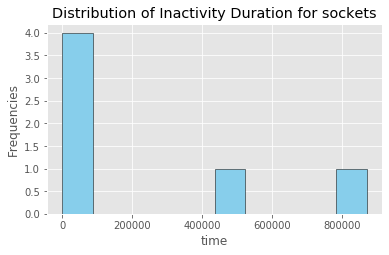

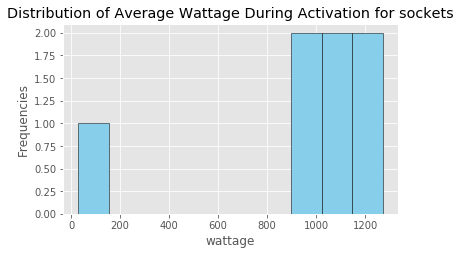

There are NO activation period for washer dryer.
There are NO activation period for washer dryer.
There are NO activation period for washer dryer.
There are NO activation period for washer dryer.
Insufficient active periods to calculate gaps.
There are NO activation period for washer dryer.
{'sockets': 415.26846}
There are NO activation period for washer dryer.


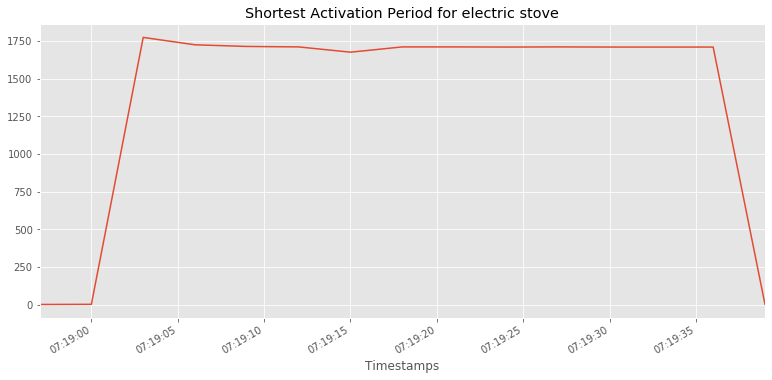

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482}


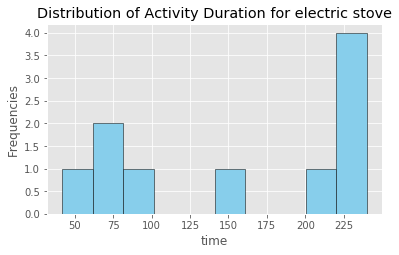

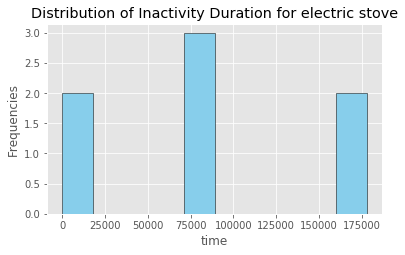

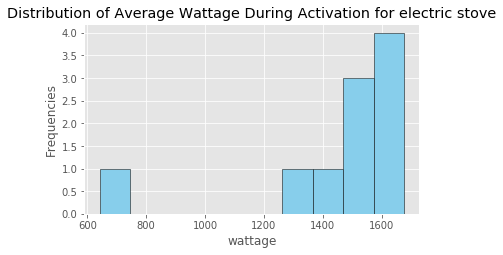

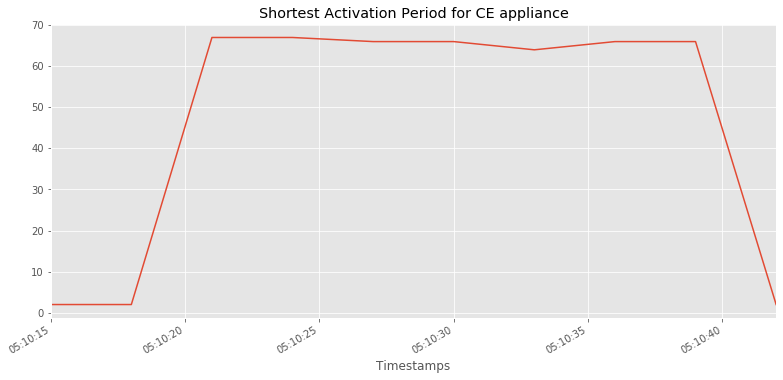

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997}


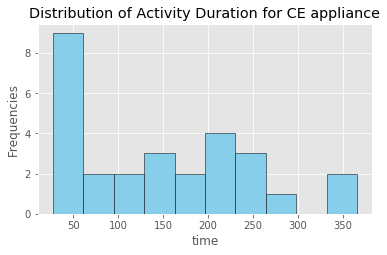

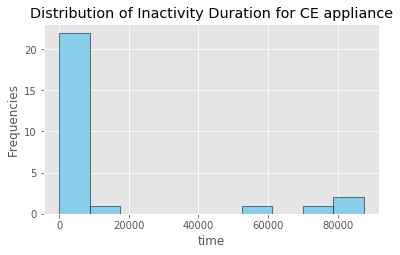

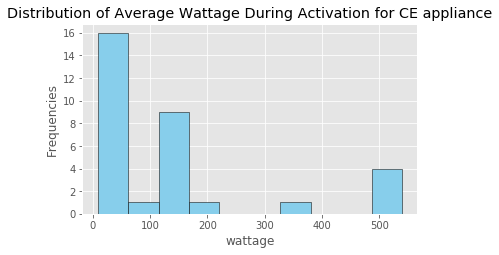

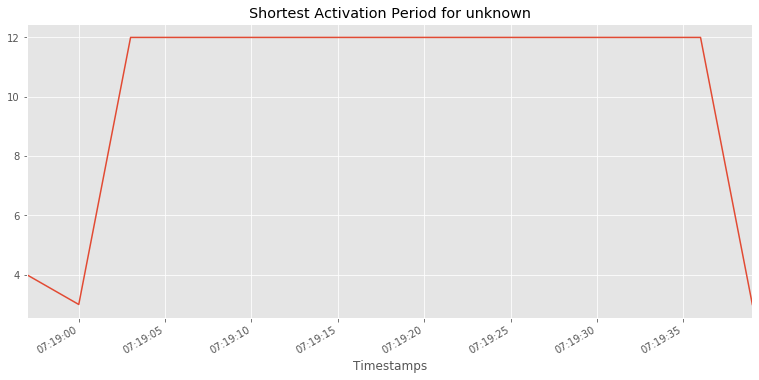

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604}


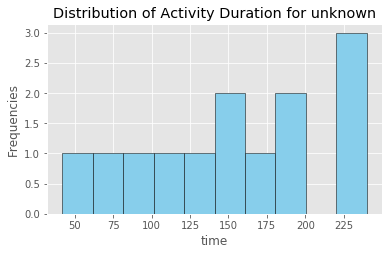

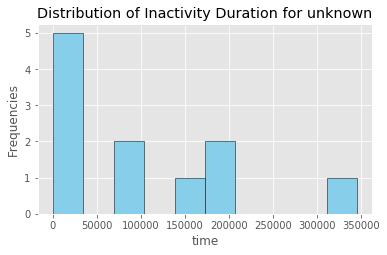

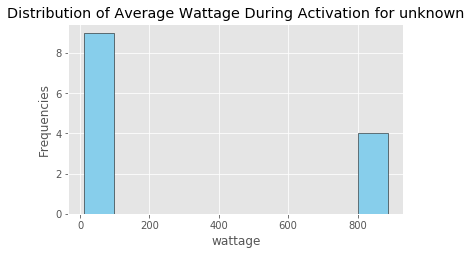

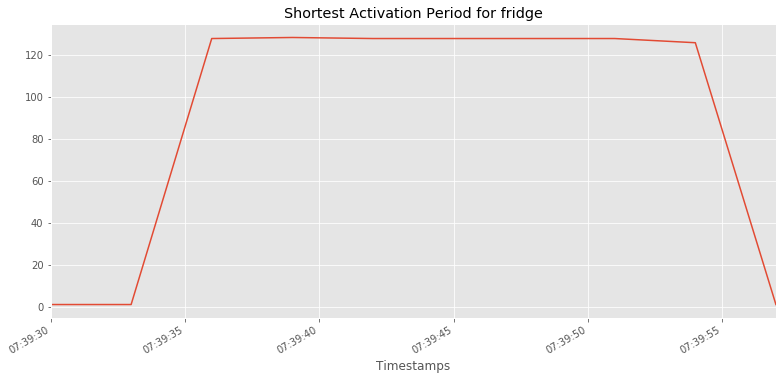

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943}


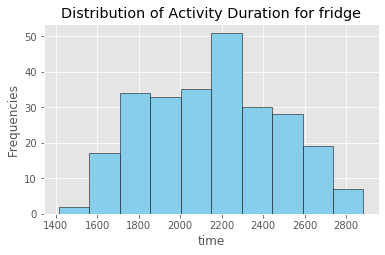

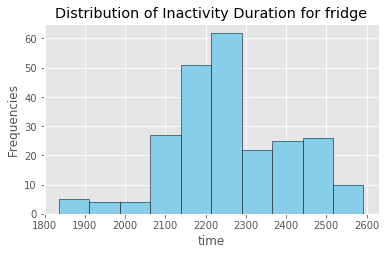

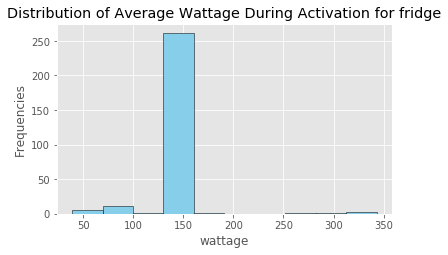

There are NO activation period for dish washer.
There are NO activation period for dish washer.
There are NO activation period for dish washer.
There are NO activation period for dish washer.
Insufficient active periods to calculate gaps.
There are NO activation period for dish washer.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943}
There are NO activation period for dish washer.


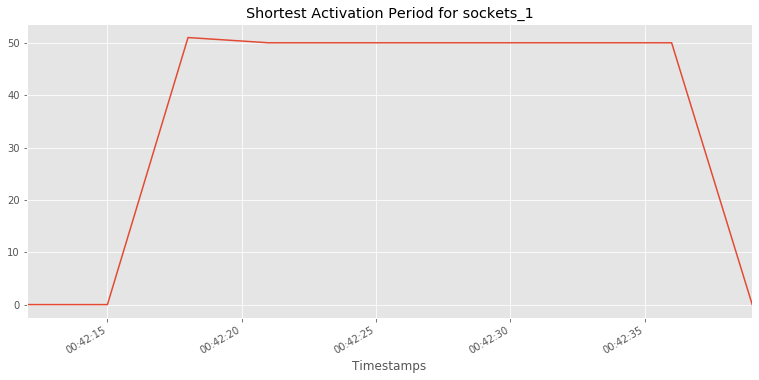

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943, 'sockets_1': 14.844656}


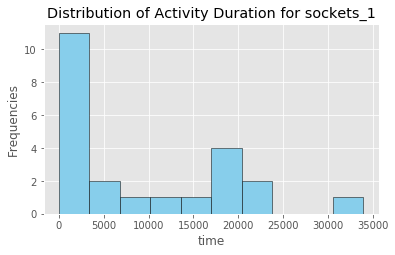

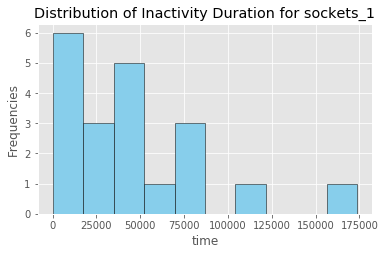

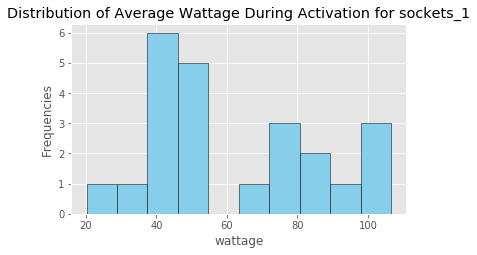

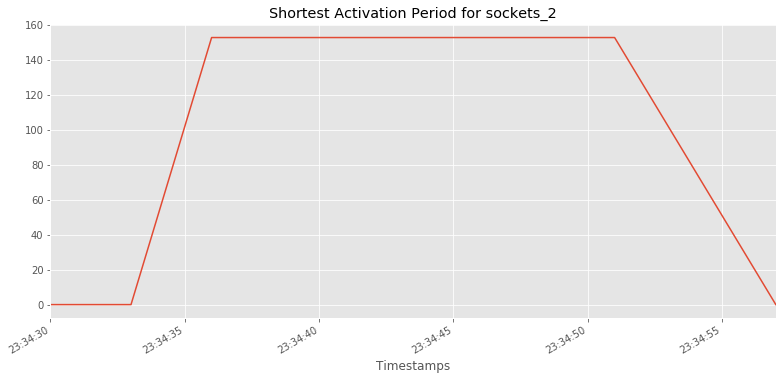

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943, 'sockets_1': 14.844656, 'sockets_2': 37.784813}


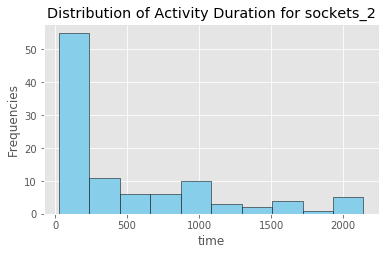

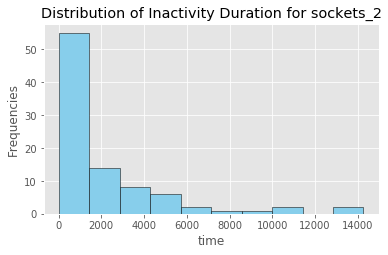

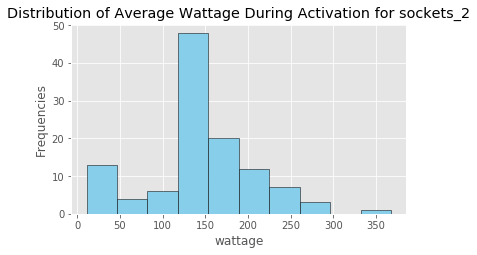

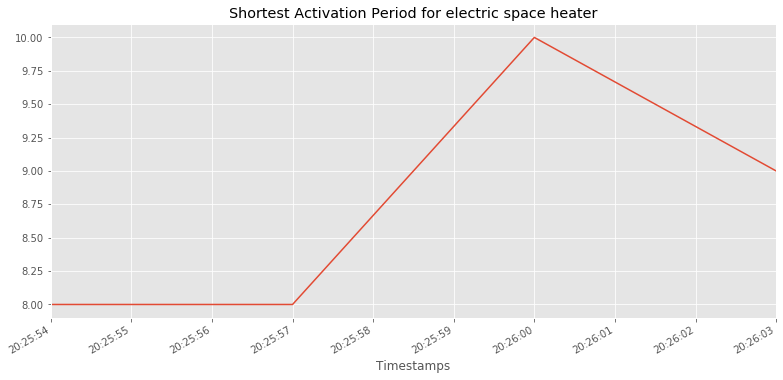

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943, 'sockets_1': 14.844656, 'sockets_2': 37.784813, 'electric space heater': 0.79364973}


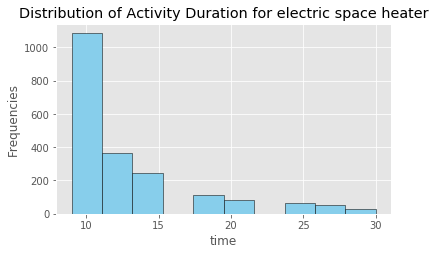

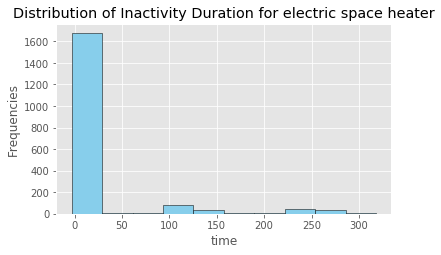

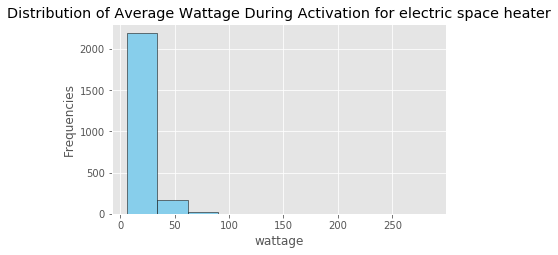

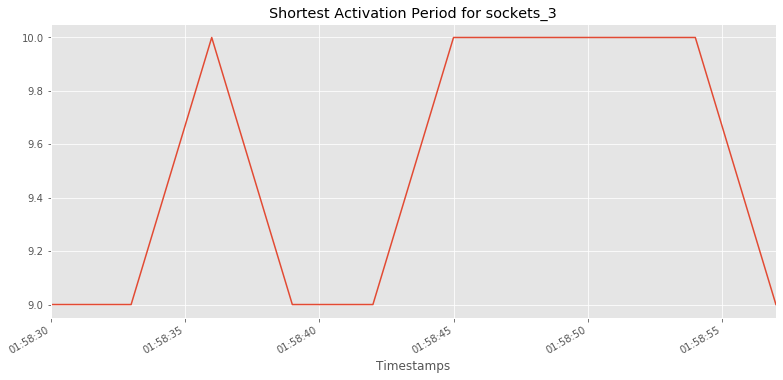

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943, 'sockets_1': 14.844656, 'sockets_2': 37.784813, 'electric space heater': 0.79364973, 'sockets_3': 2.5243742}


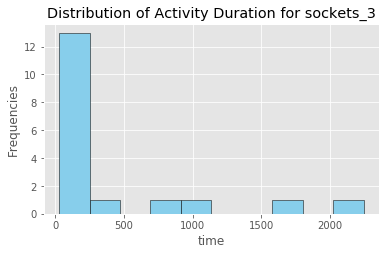

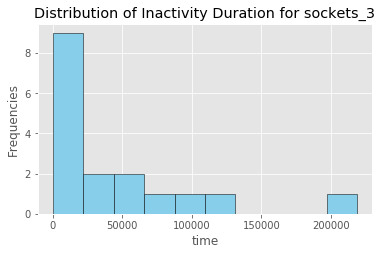

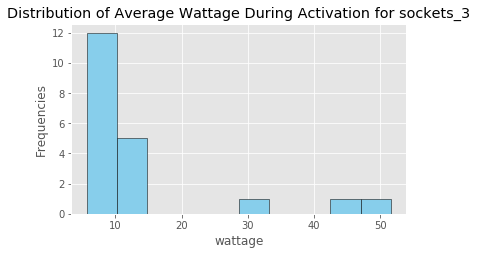

There are NO activation period for light.
There are NO activation period for light.
There are NO activation period for light.
There are NO activation period for light.
Insufficient active periods to calculate gaps.
There are NO activation period for light.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943, 'sockets_1': 14.844656, 'sockets_2': 37.784813, 'electric space heater': 0.79364973, 'sockets_3': 2.5243742}
There are NO activation period for light.


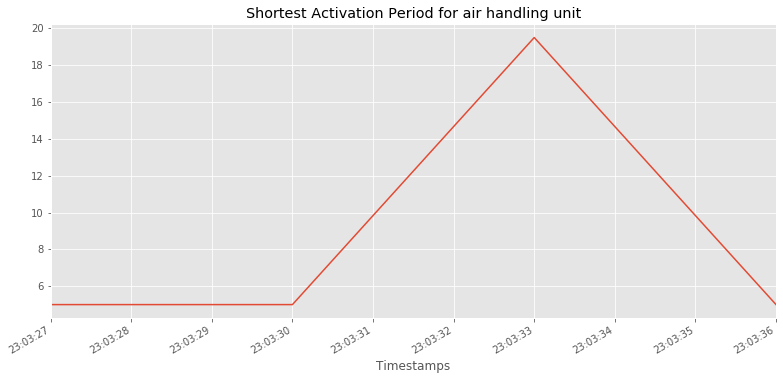

SUCCESS! Exported the longest ap and shortest ap plots.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943, 'sockets_1': 14.844656, 'sockets_2': 37.784813, 'electric space heater': 0.79364973, 'sockets_3': 2.5243742, 'air handling unit': 30.316298}


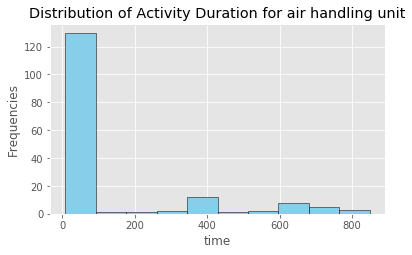

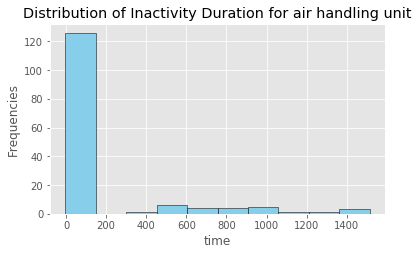

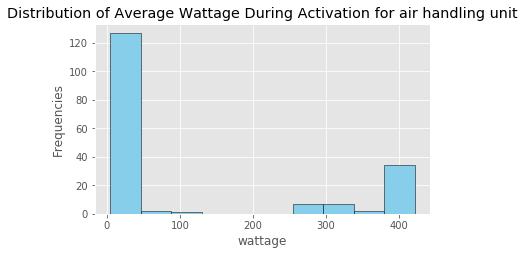

Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.


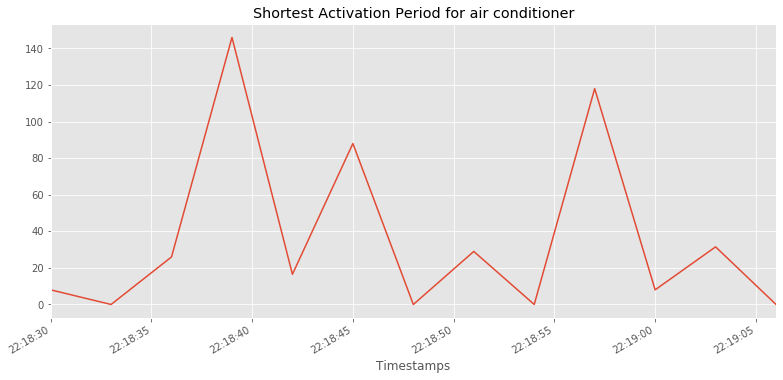

SUCCESS! Exported the longest ap and shortest ap plots.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
{'sockets': 415.26846, 'electric stove': 521.3482, 'CE appliance': 24.705997, 'unknown': 75.18604, 'fridge': 13.853943, 'sockets_1': 14.844656, 'sockets_2': 37.784813, 'electric space heater': 0.79364973, 'sockets_3': 2.5243742, 'air handling unit': 30.316298, 'air conditioner': 174.53075}


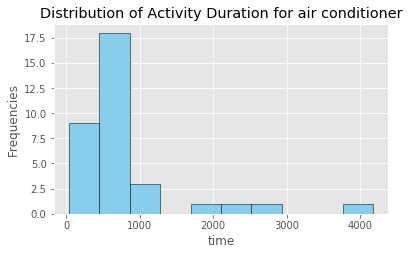

Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.


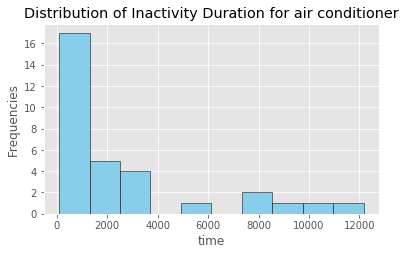

Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.


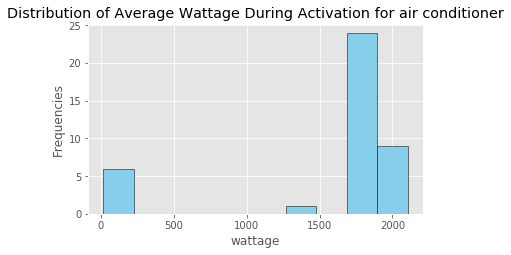

Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=17, building=6, dataset='REDD')     
Done loading data all meters for this chunk.


In [23]:
data_set_profile(redd)